In [21]:
import argparse
import datetime as dt
import sys


try:
    from cheta import fetch_sci as fetch
    from kadi import events
except ImportError:
    sys.exit("Failed to import cheta (aka ska). Make sure you're using the latest version of the ska runtime environment (and that you have the conda environment initialized!).")

import event_times
import msidlists
import plot_stylers
from chandratime import convert_to_doy, cxctime_to_datetime as cxc2dt
from monitor_comms import convert_bus_current_to_dn
from plot_motors import make_motor_plots
from plot_rates import make_shield_plot
from plot_thermals import make_thermal_plots
from heartbeat import timestamp_string

import matplotlib
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import numpy as np
import pytz

%config InlineBackend.figure_format='retina'

In [22]:
# fetch.data_source.set('maude allow_subset=False')
# fetch.data_source.set('maude allow_subset=True') # only if you're updated on ska
fetch.data_source.set('maude allow_subset=True') # only if you're updated on ska


In [10]:
lookback_days = 50

In [12]:

# msidlist = ['2C15PALV', '2P15VAVL', '2TLEV1RT', '2N15VAVL', '2P05VAVL', '2SHEV1RT', '2VLEV1RT']
state_msids = ['215PCAST']

lookback_time = dt.datetime.now() - dt.timedelta(days=lookback_days)

# Convert this to a YYYY:DOY string like '2023:101'
pull_telem_from = convert_to_doy(lookback_time)

In [13]:

states = fetch.MSIDset(state_msids, start=pull_telem_from)


In [14]:

hrc_is_on = states['215PCAST'].vals == 'ON'

# find the indices where telem['215PCAST'].vals switches from 'ON' to 'OFF'
power_toggle_indices = np.where(np.diff(hrc_is_on) == 1)[0]


# Take every two elements of the power_toggle_indices array and convert them into a tuple (for tstart, tstop)

index_iterator = iter(power_toggle_indices)
start_stop_indices = [*zip(index_iterator, index_iterator)]

start_stop_times = []

for interval in start_stop_indices:
    tstart = states['215PCAST'].times[interval[0]]
    tstop = states['215PCAST'].times[interval[1]] 

    # sometimes bad data will show one-frame power toggles, so let's only consider intervals longer than, say, 3 minutes

    if tstop - tstart > 3*60:
        start_stop_times.append((tstart, tstop))

print(start_stop_times)

[(797802636.552, 797816900.453), (797998514.065, 798009563.565), (798241803.98, 798256469.681), (798406341.09, 798421207.691), (798480071.395, 798494937.996), (799040582.431, 799055449.032), (799182216.94, 799192462.841), (799262777.845, 799277644.446), (799643282.469, 799646697.77), (799766434.177, 799776880.978), (799848200.482, 799858647.283), (800025595.194, 800040461.795), (800197967.405, 800208414.206), (800258237.409, 800273104.01), (800436636.62, 800451503.221), (800643963.384, 800659030.885), (800694791.087, 800709657.688), (800911361.301, 800926027.002), (800999757.306, 801014623.907), (801236216.622, 801251083.223), (801314165.827, 801329032.428), (801923294.665, 801933540.566)]


/var/folders/p1/wkgwvp8j2hd_mkyz4hp5qbg40000gn/T/ipykernel_23465/3849349809.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,8))


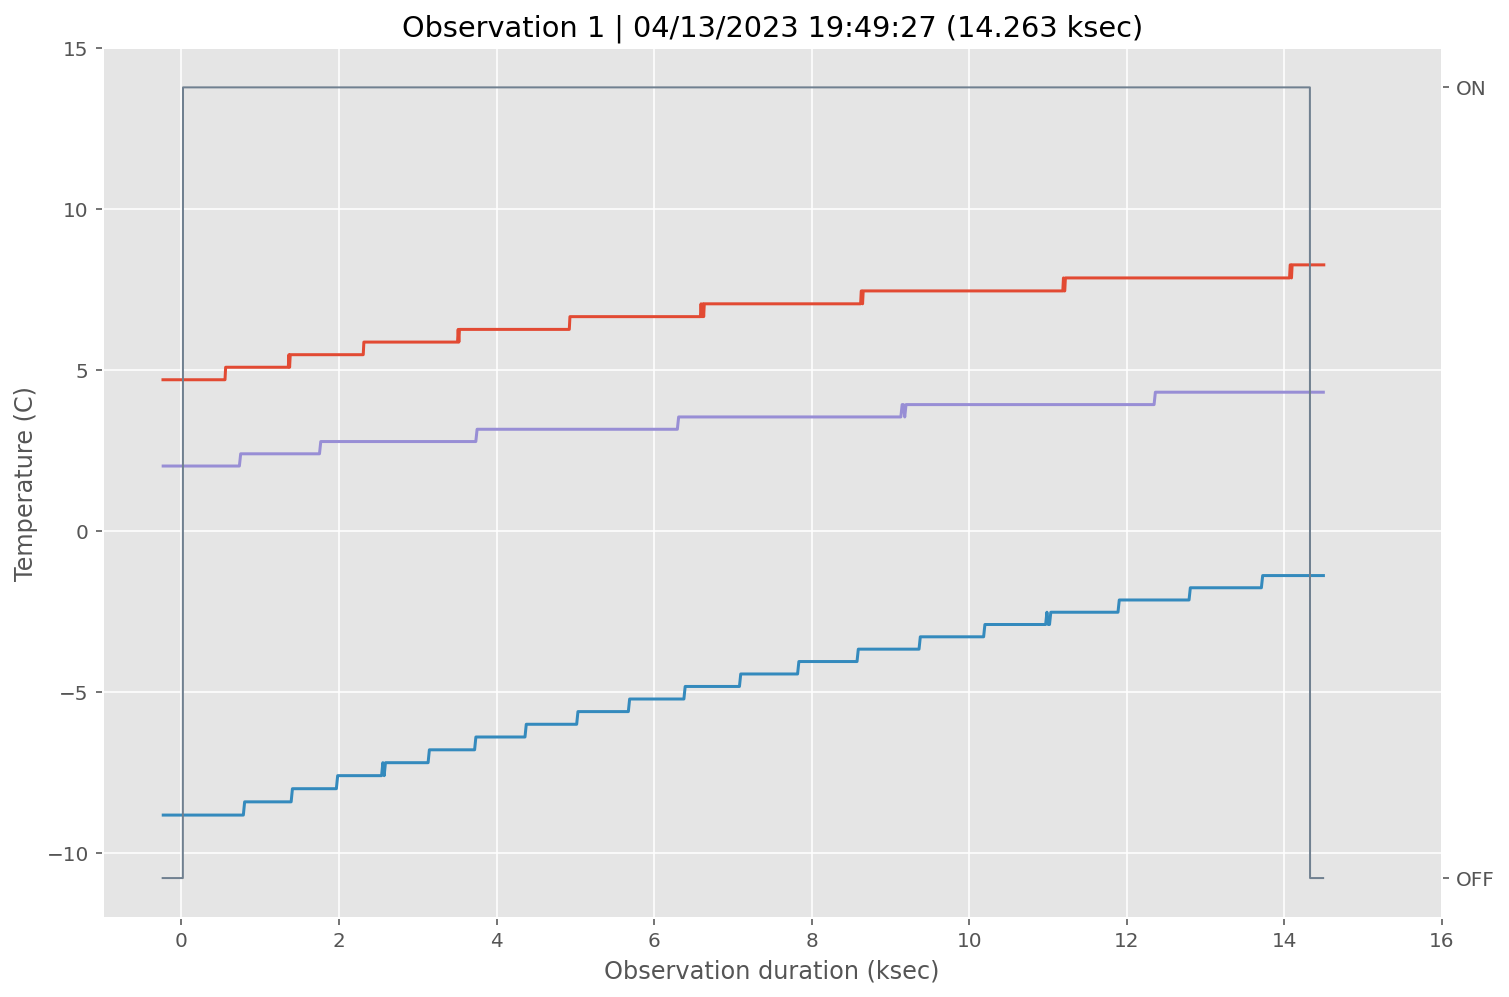

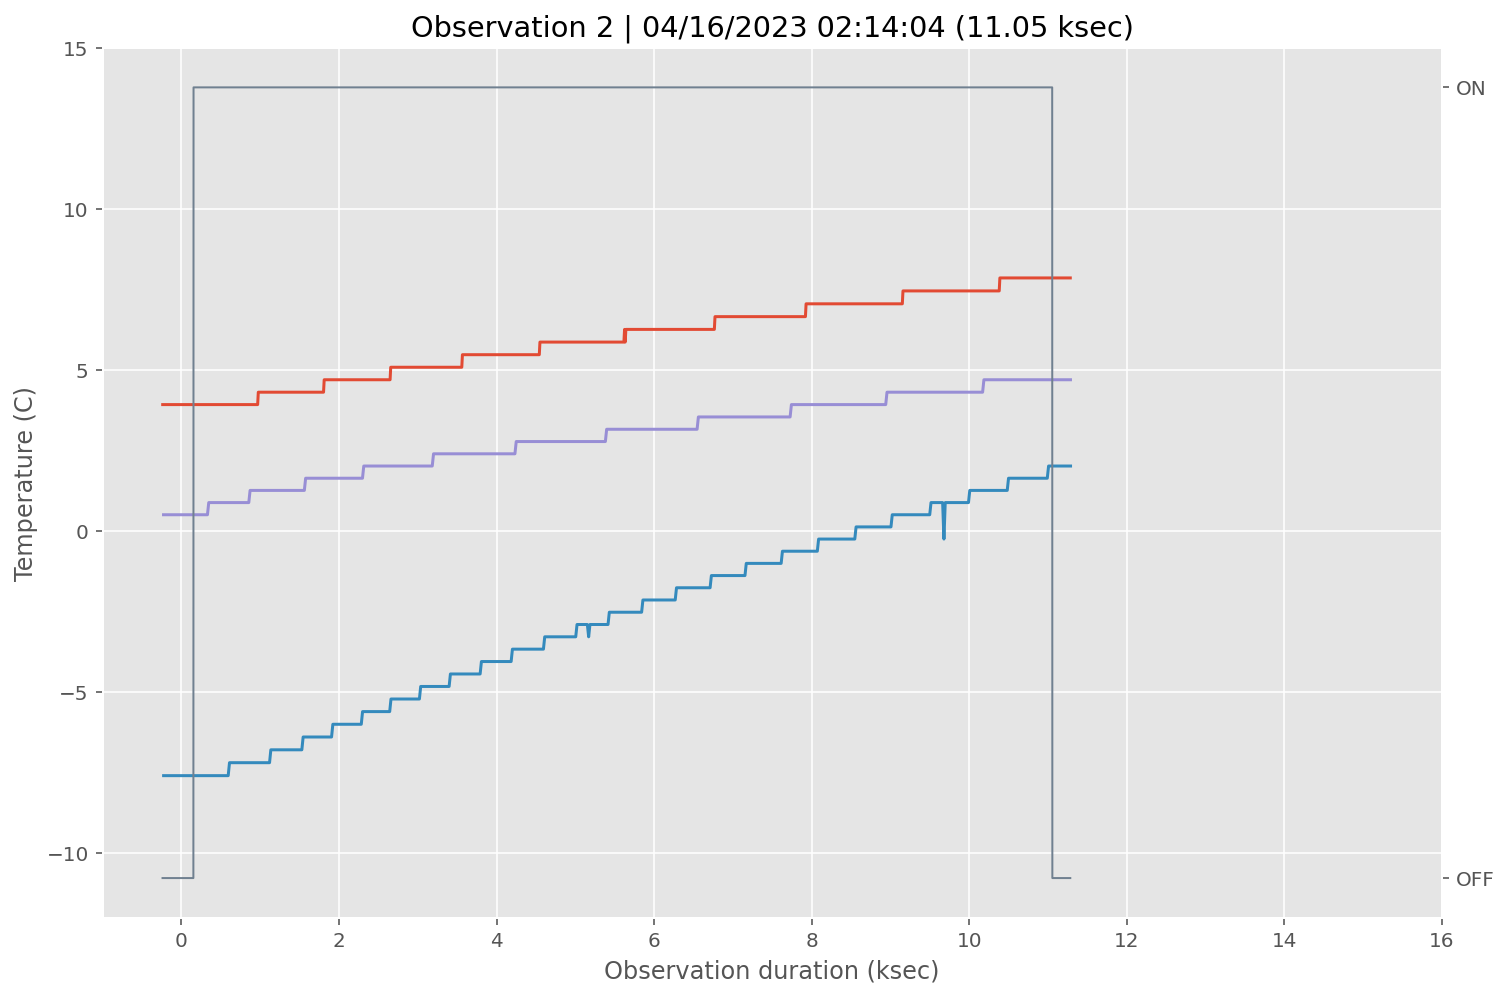

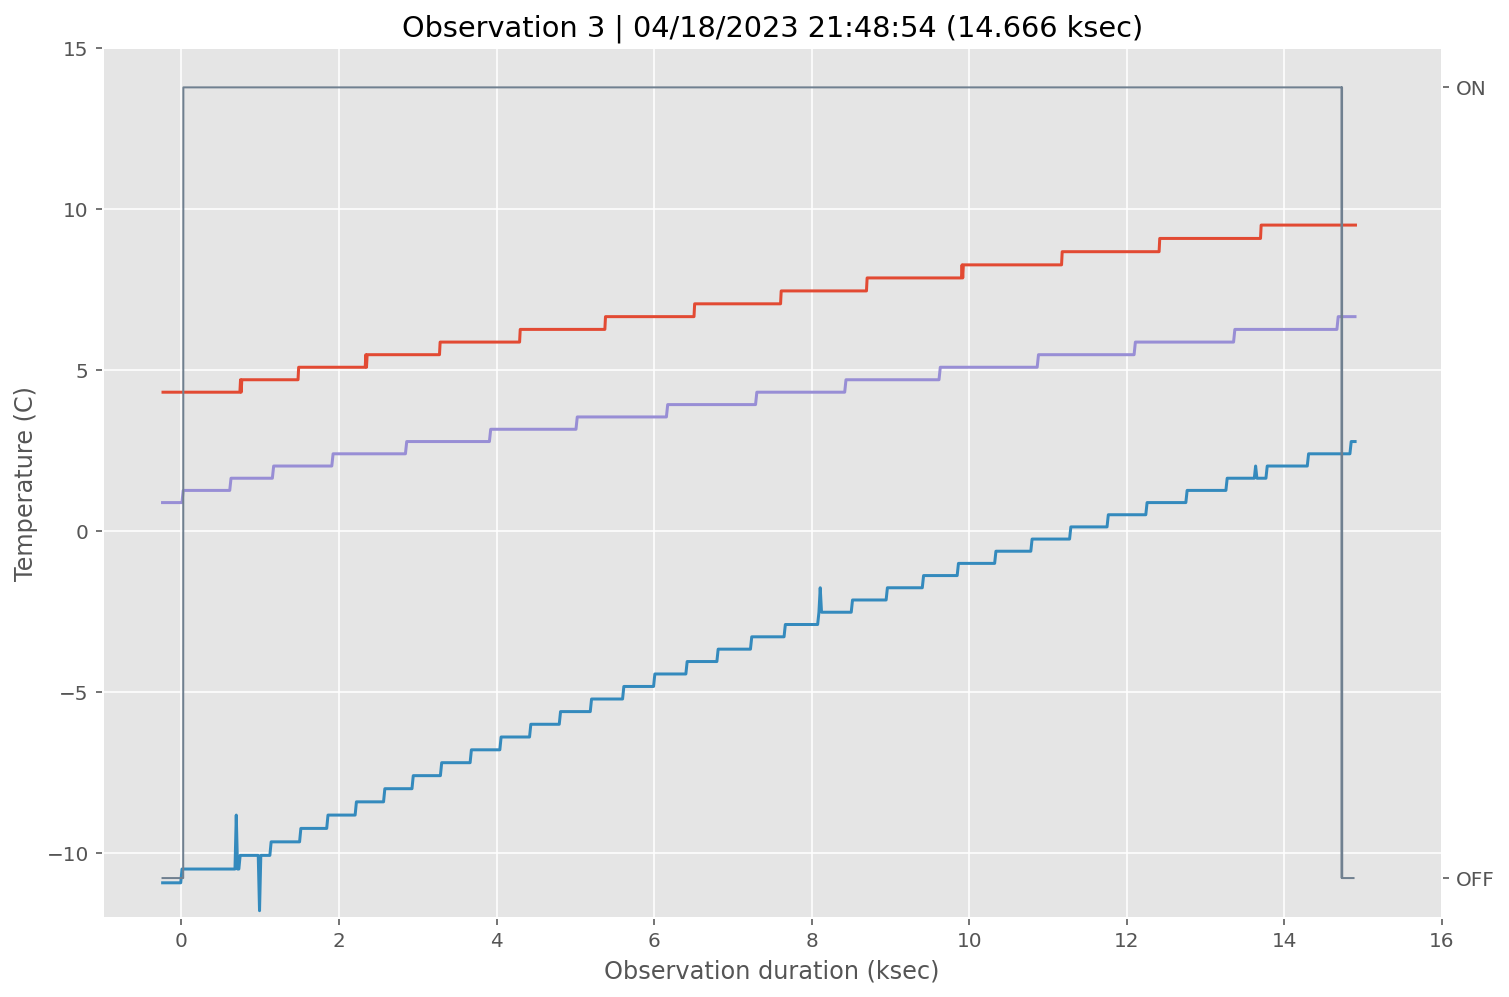

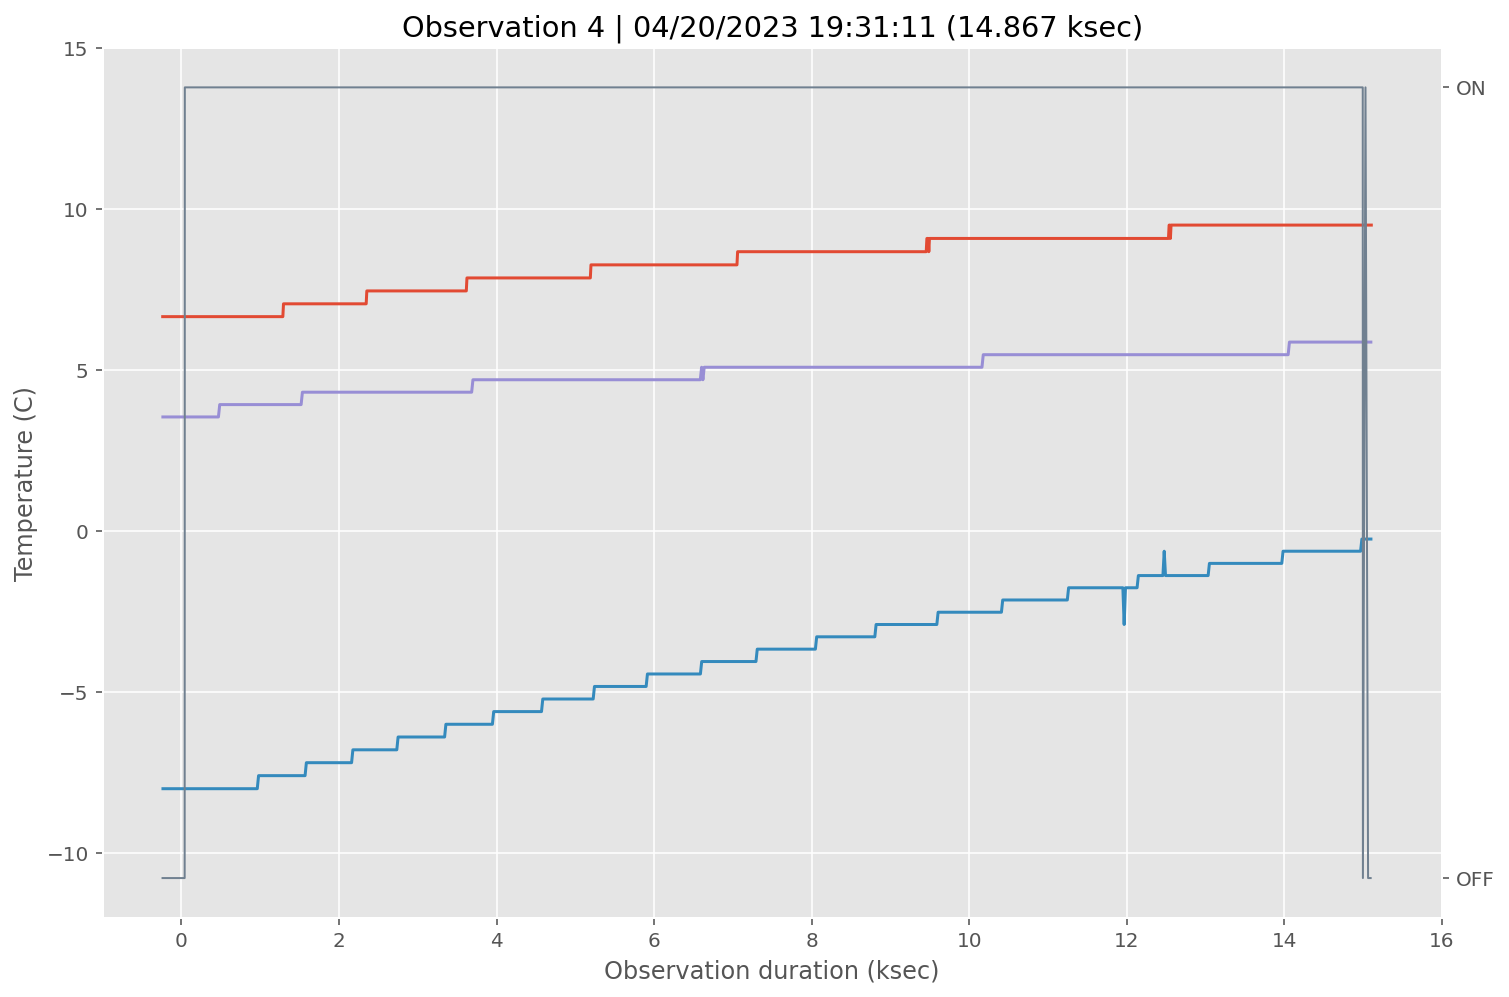

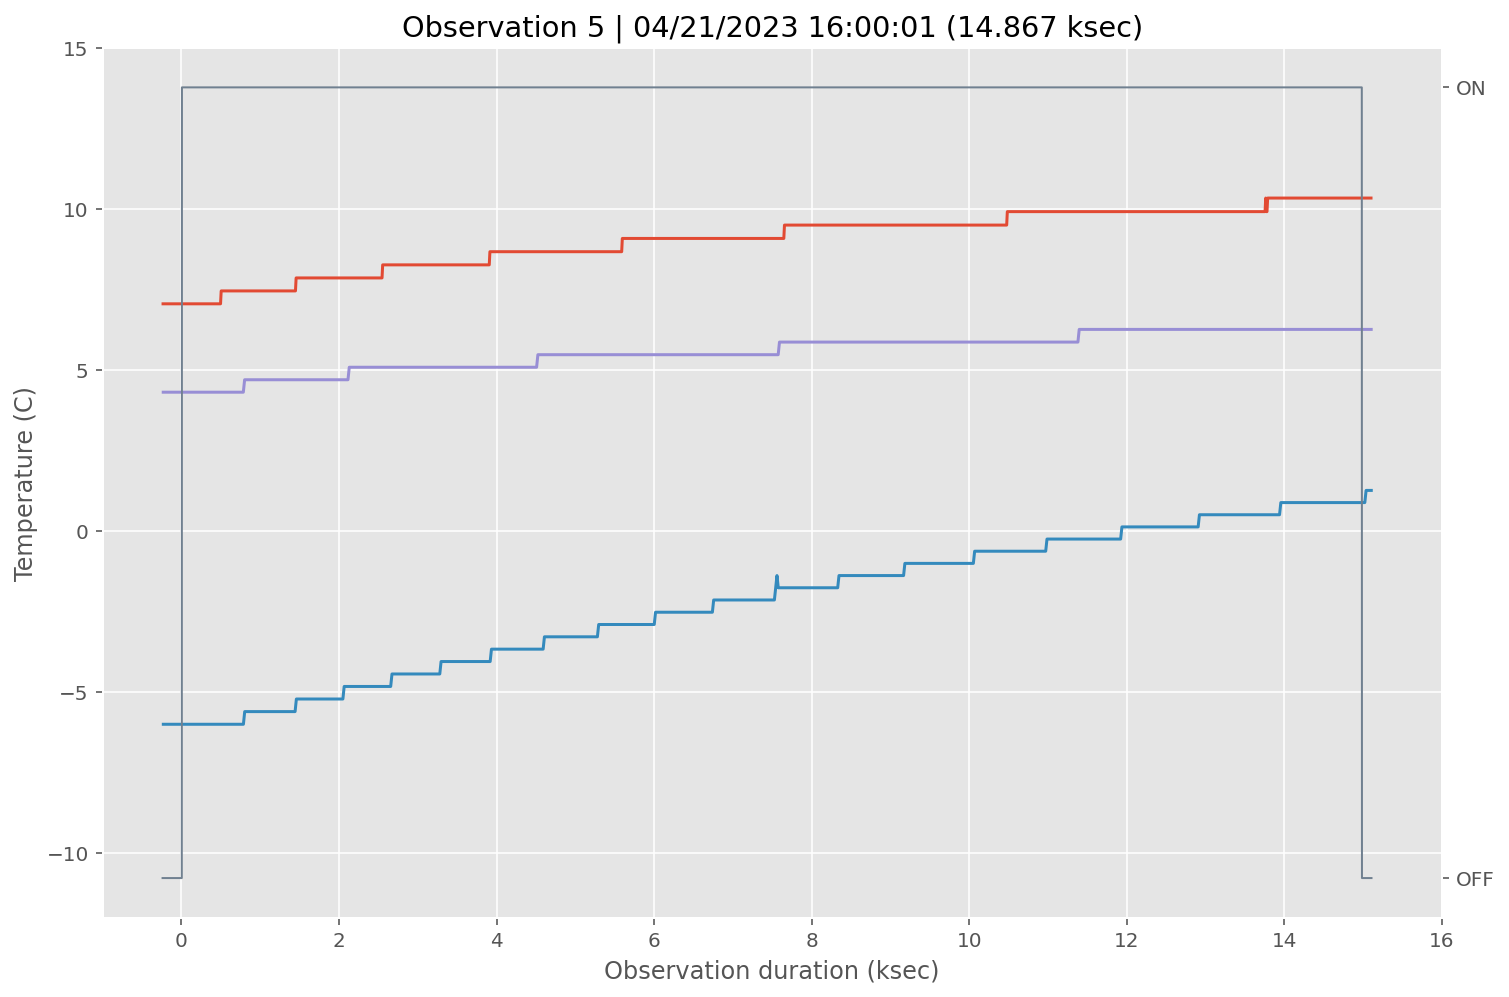

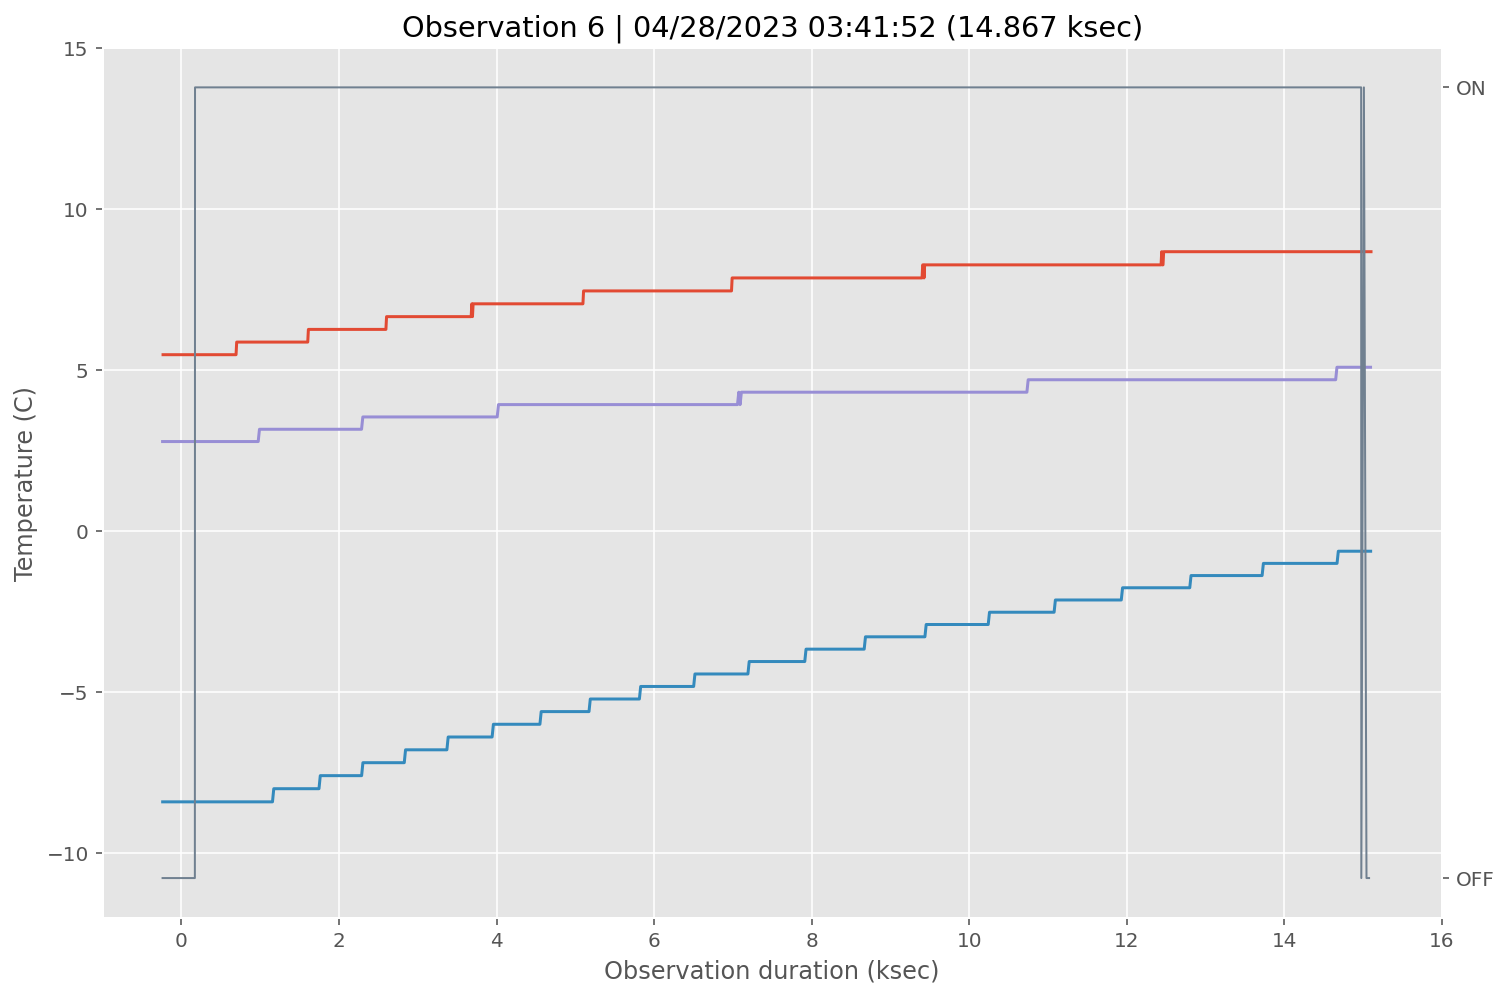

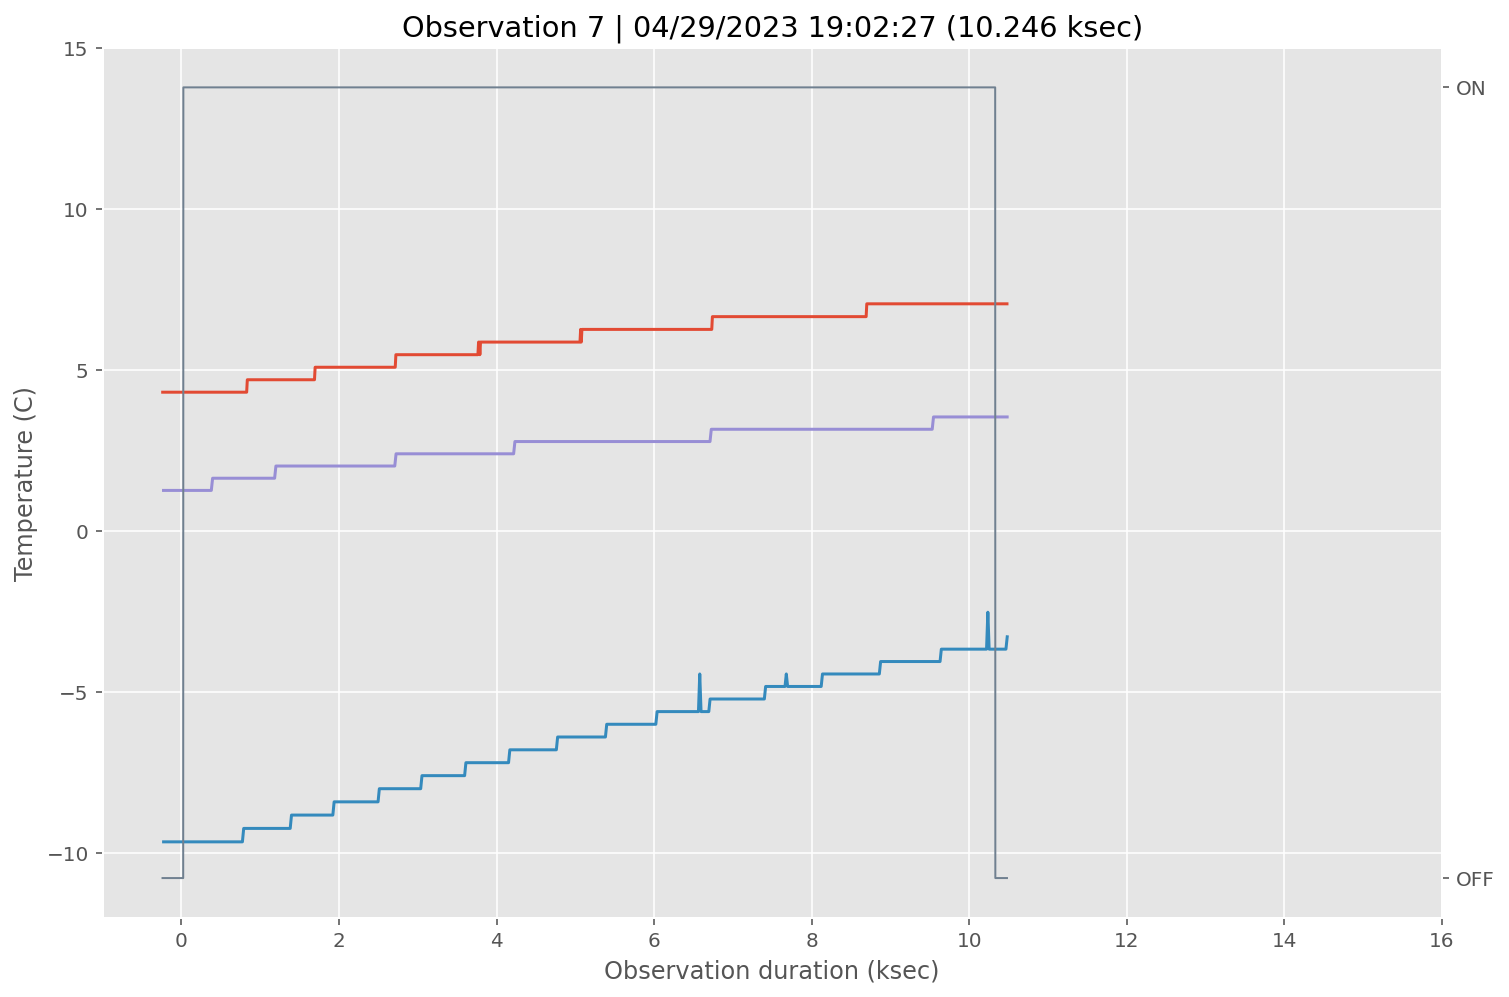

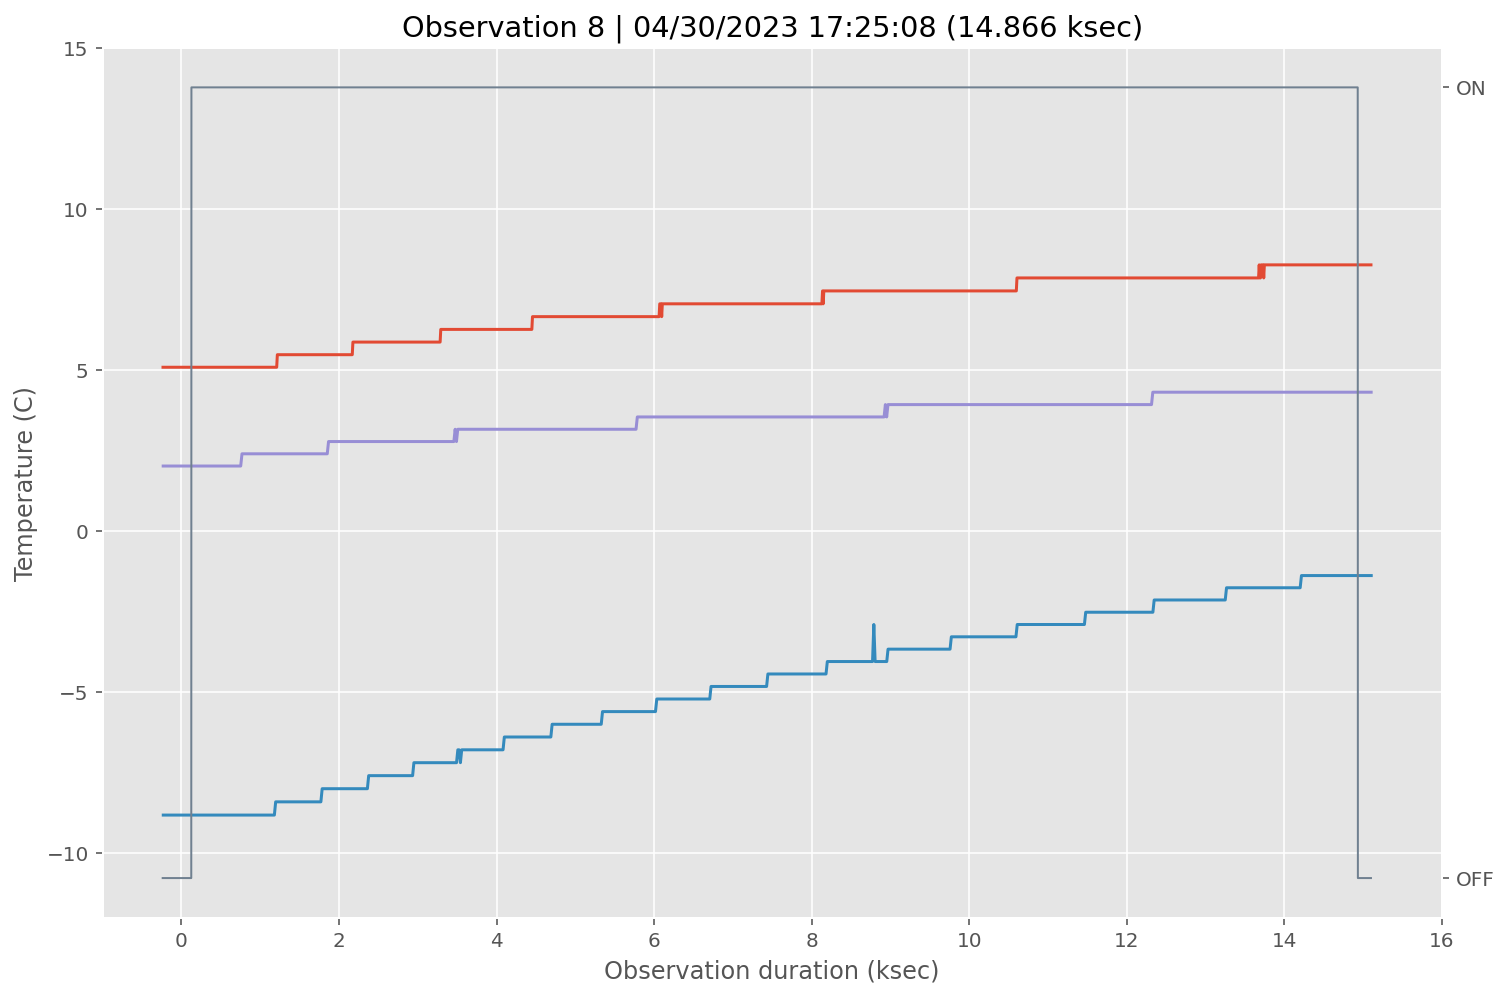

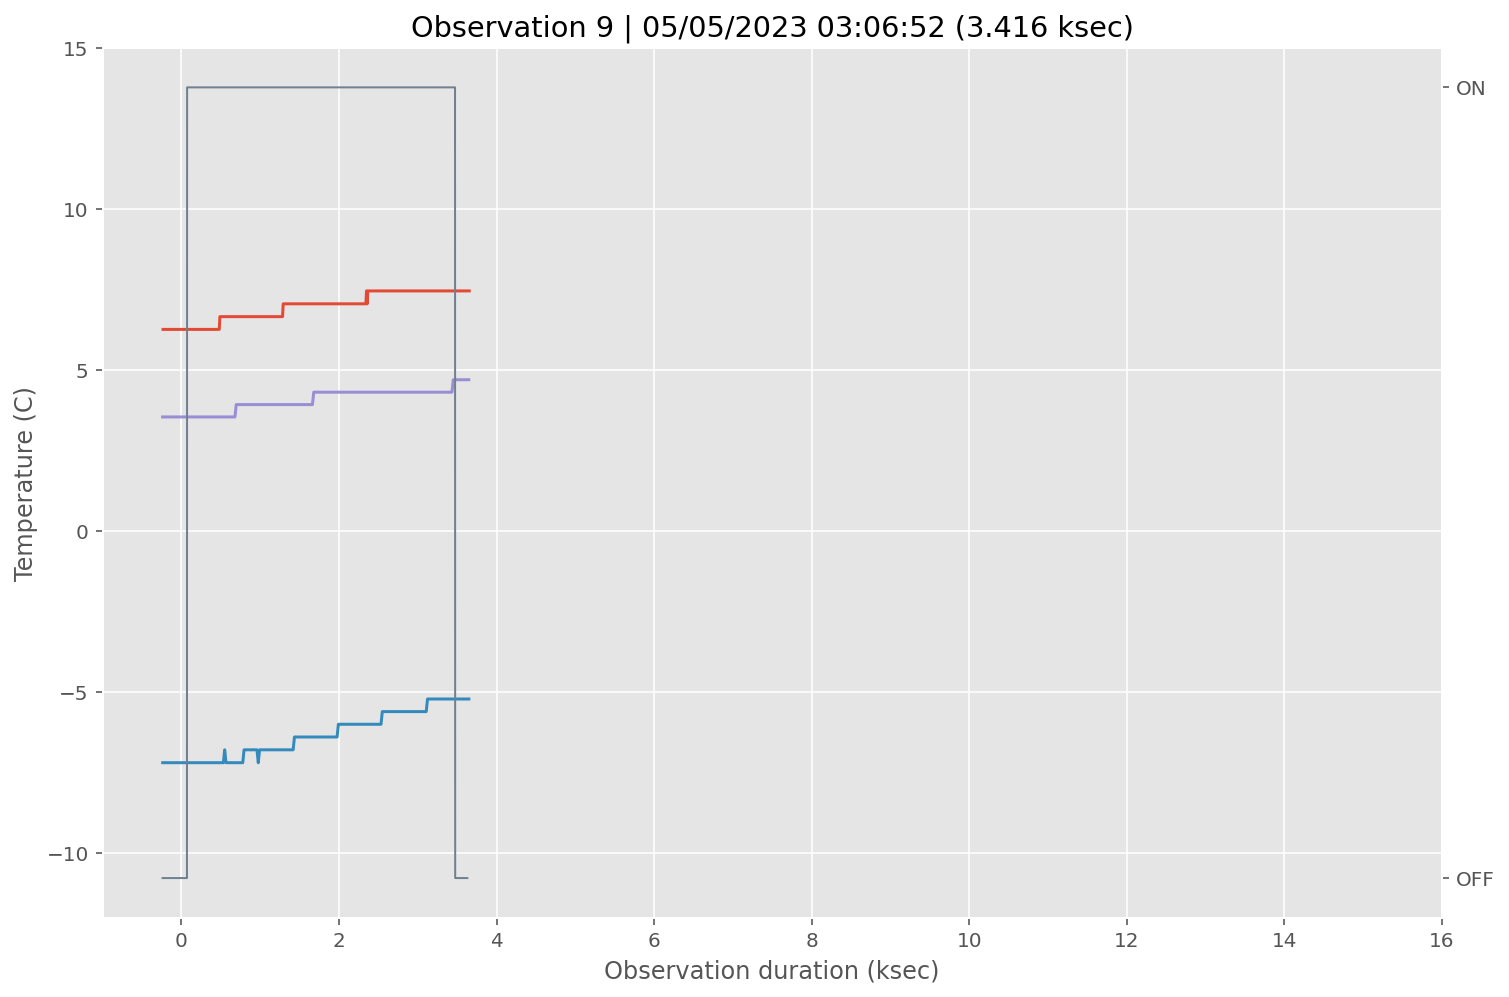

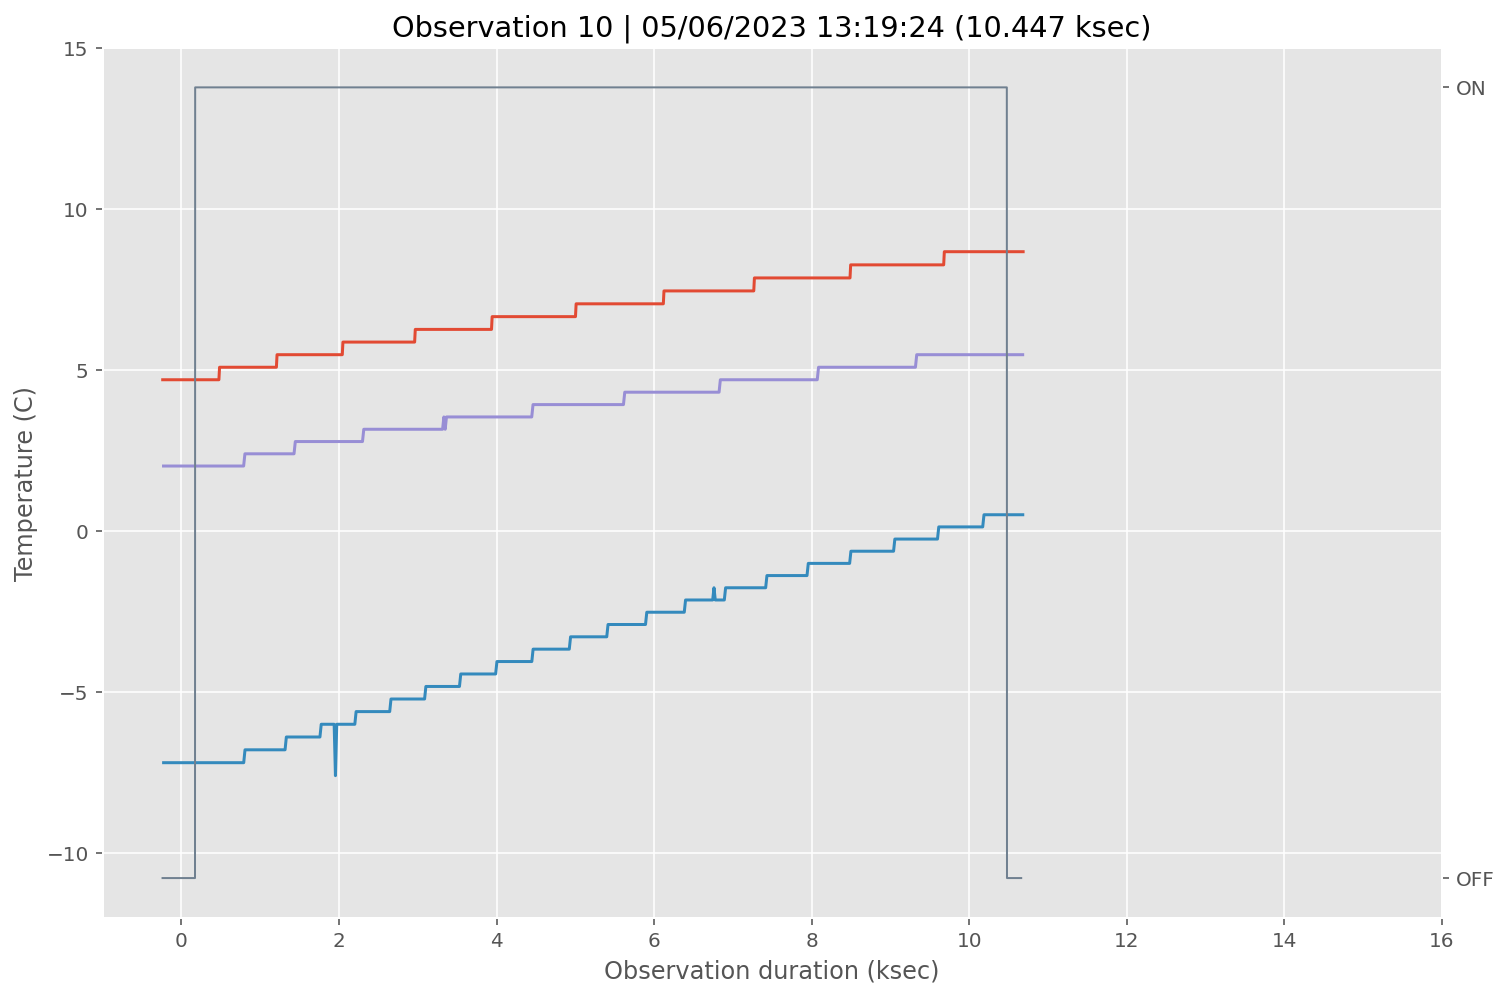

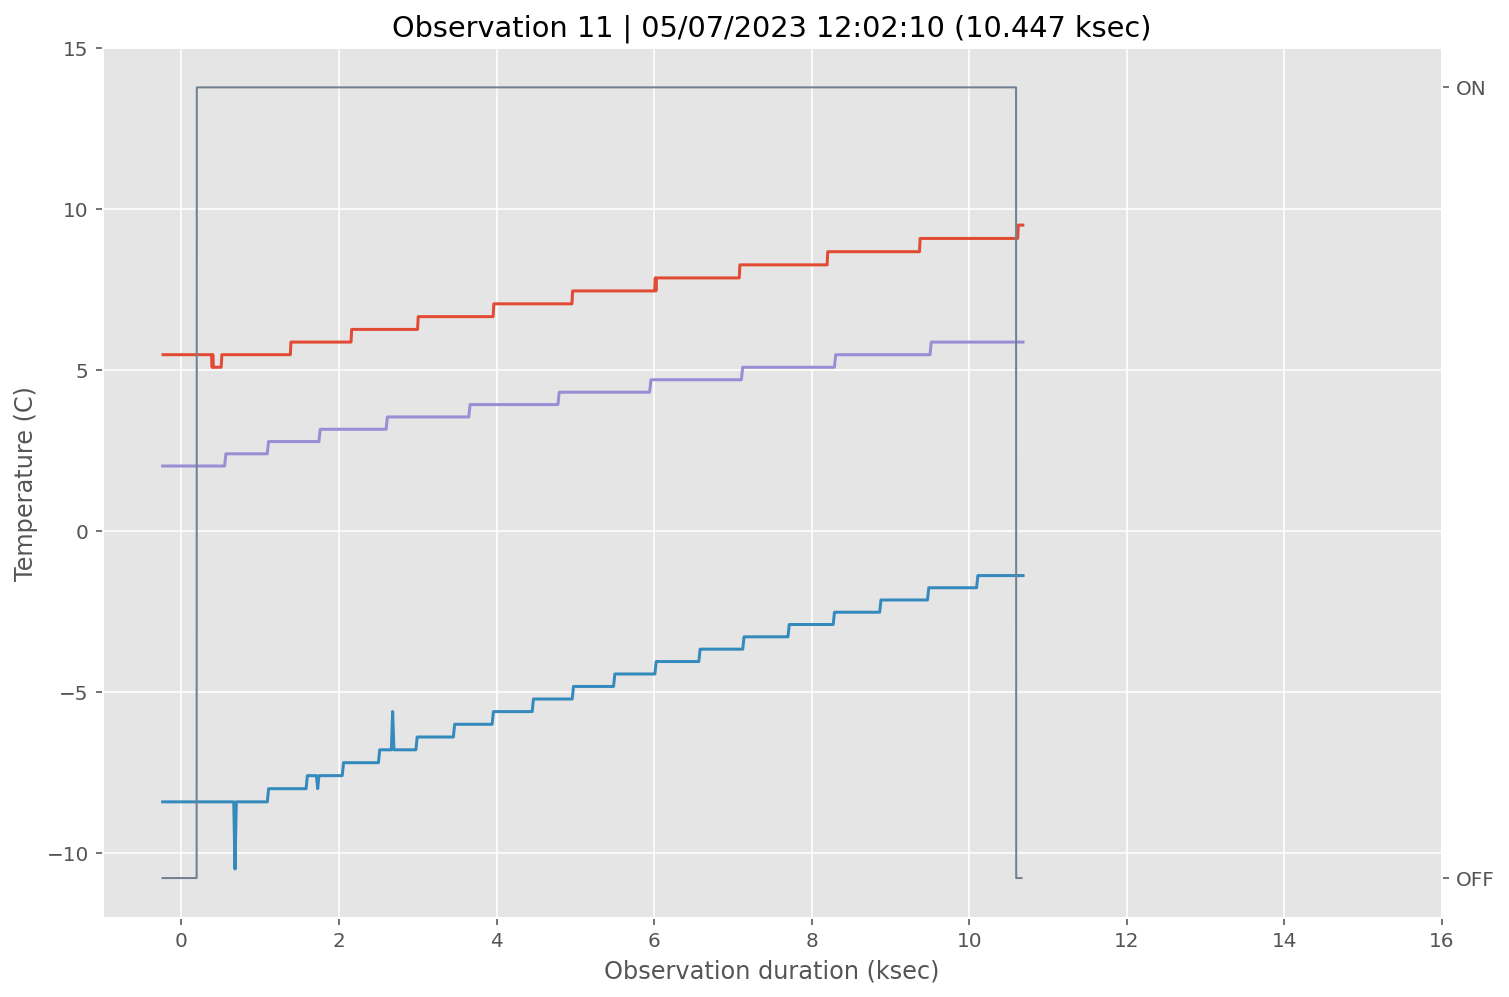

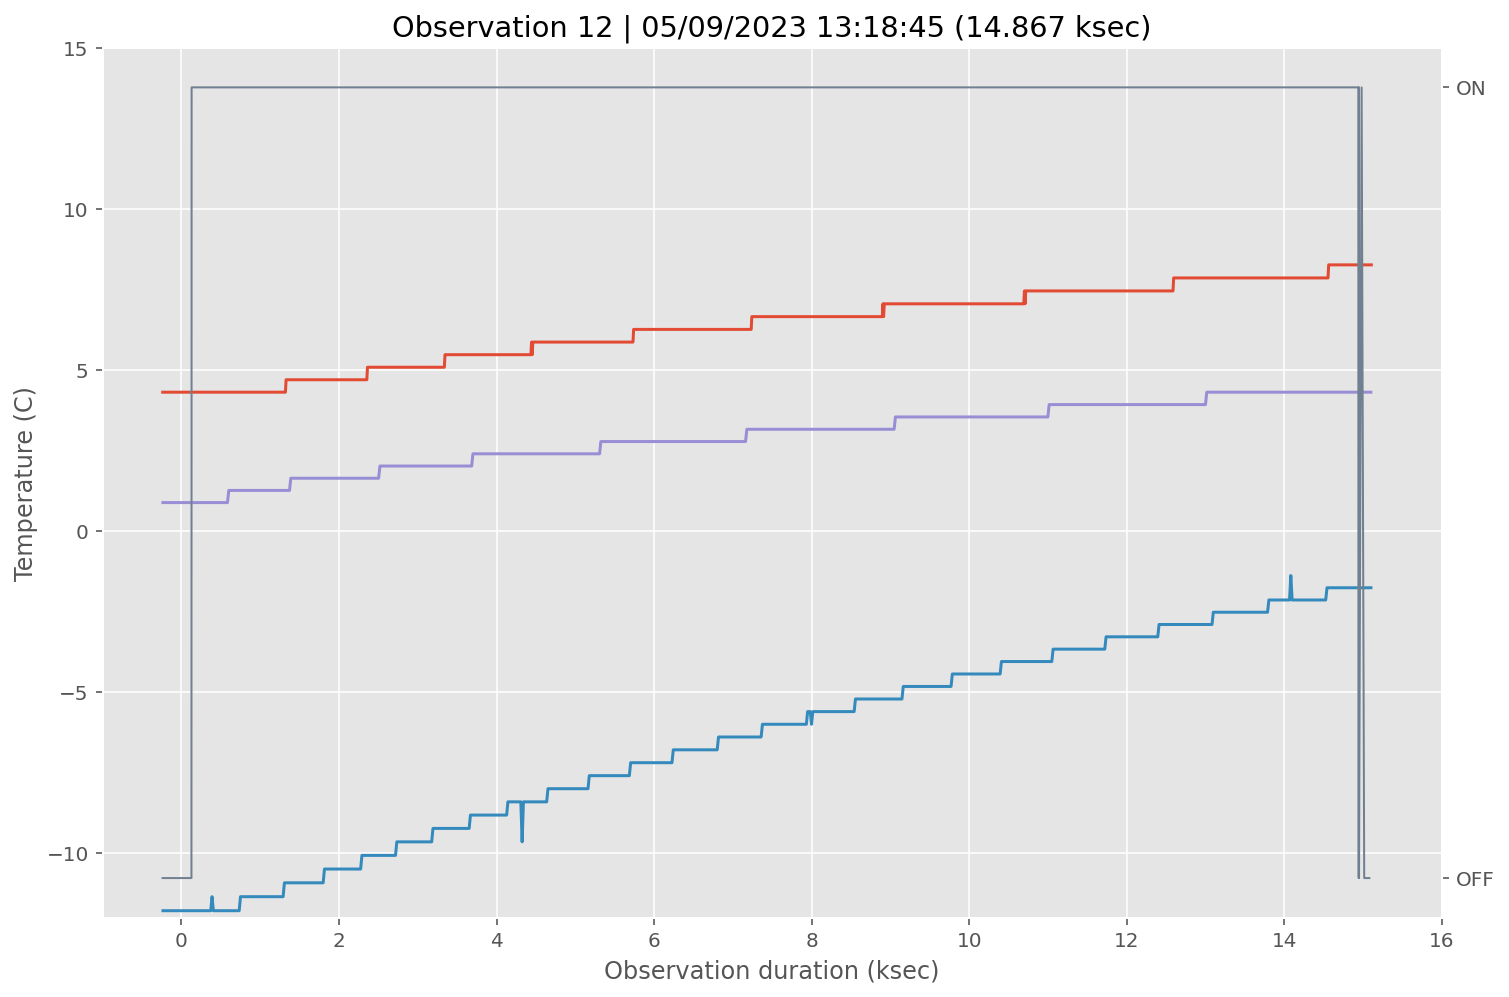

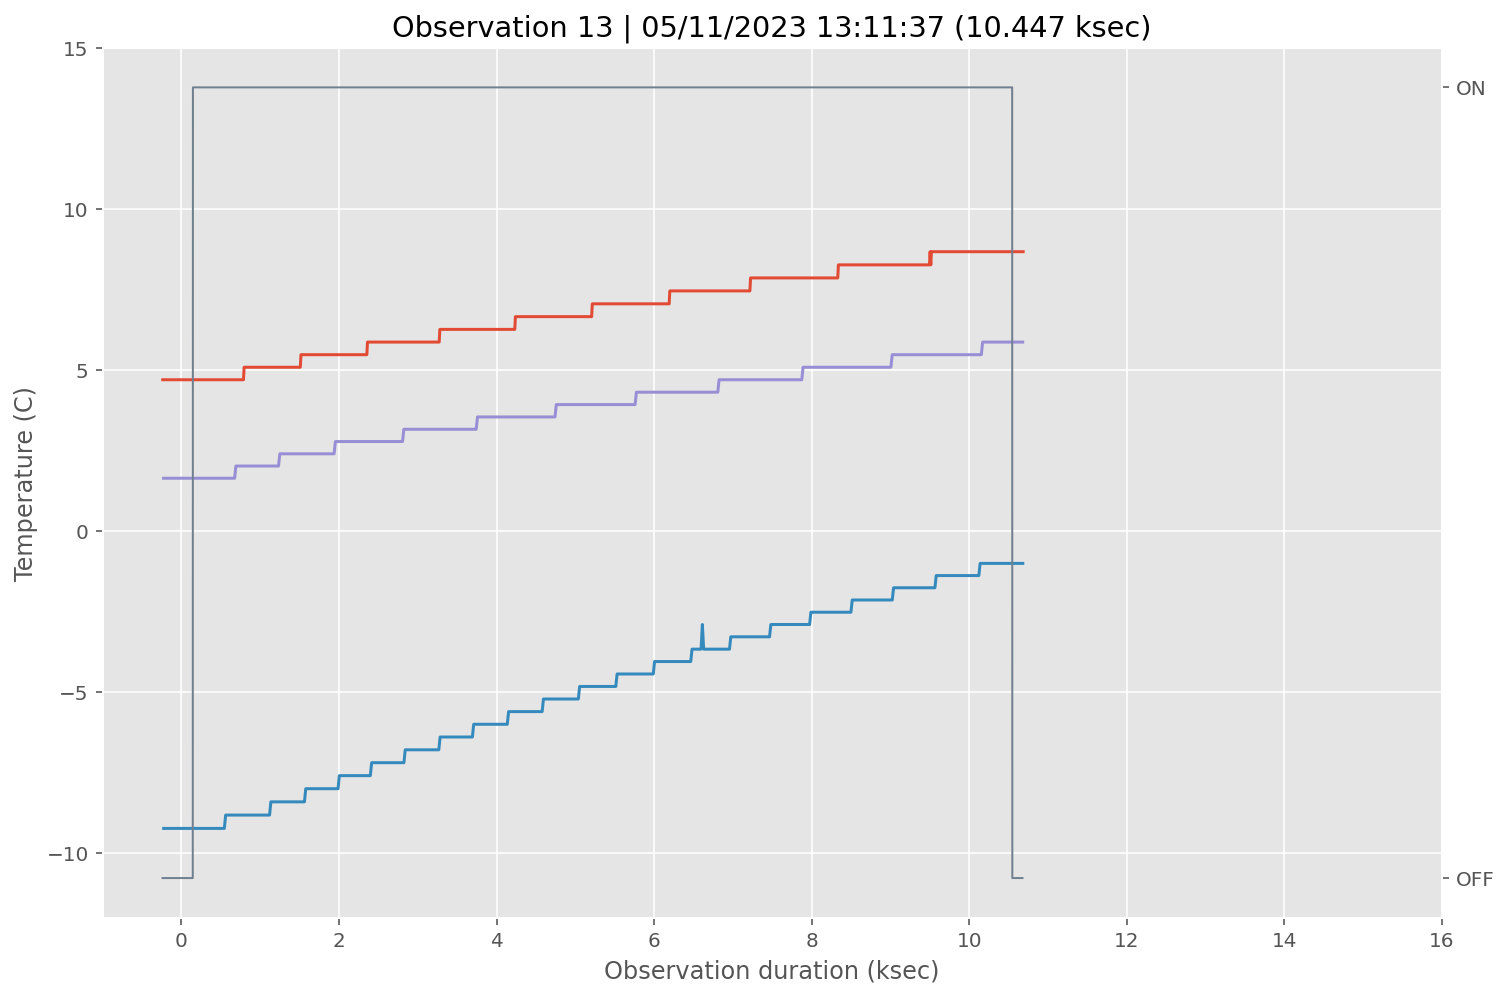

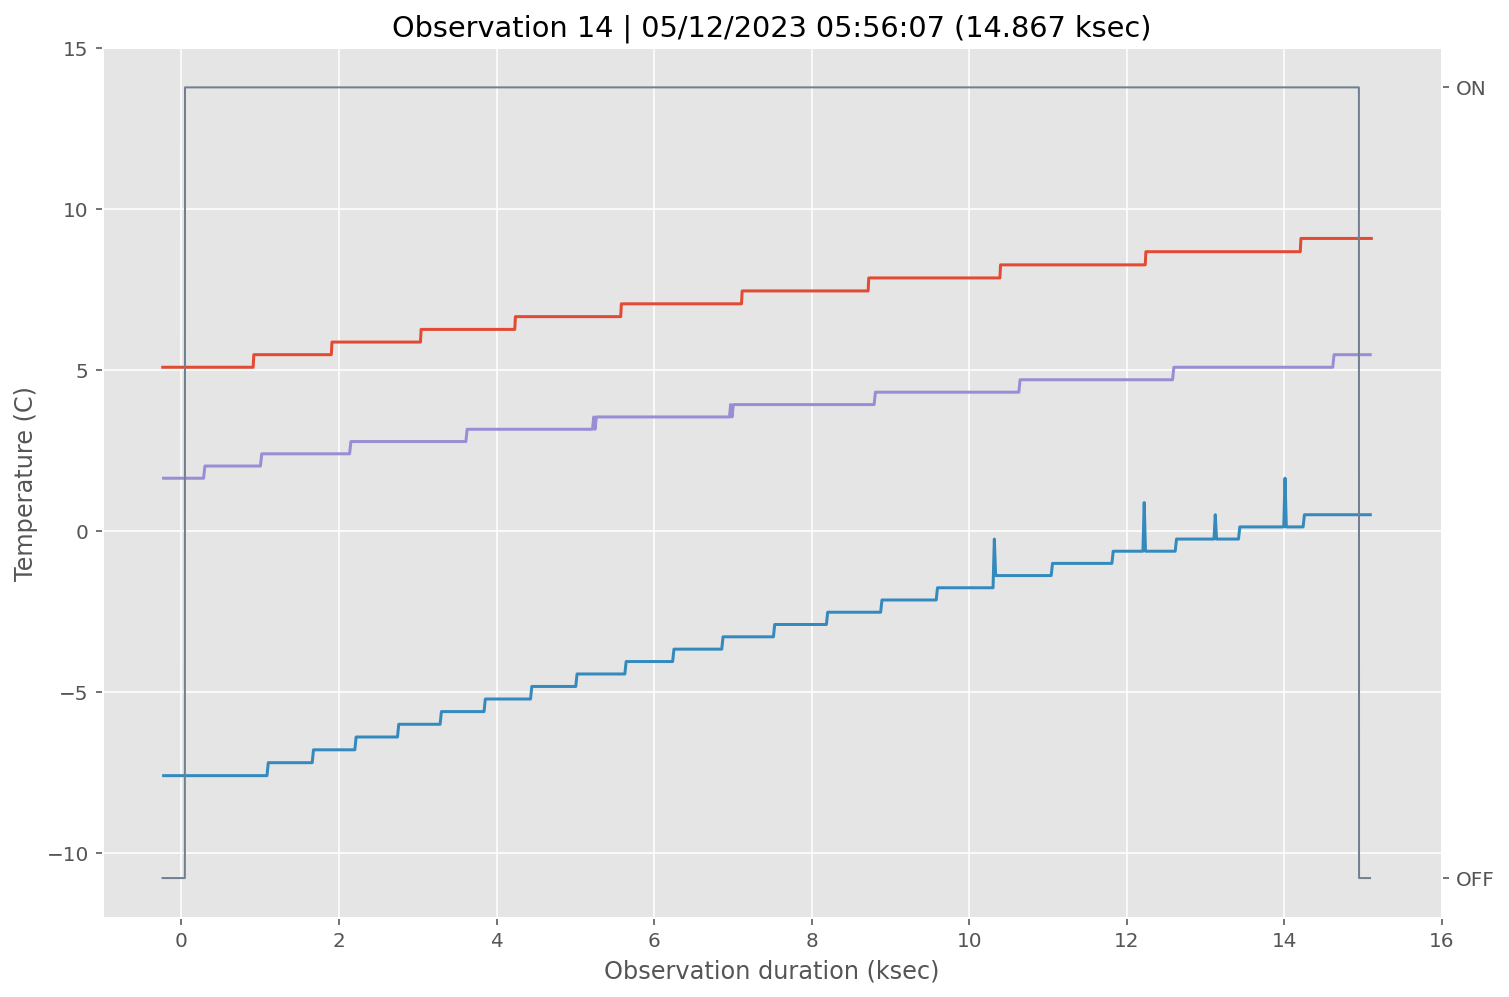

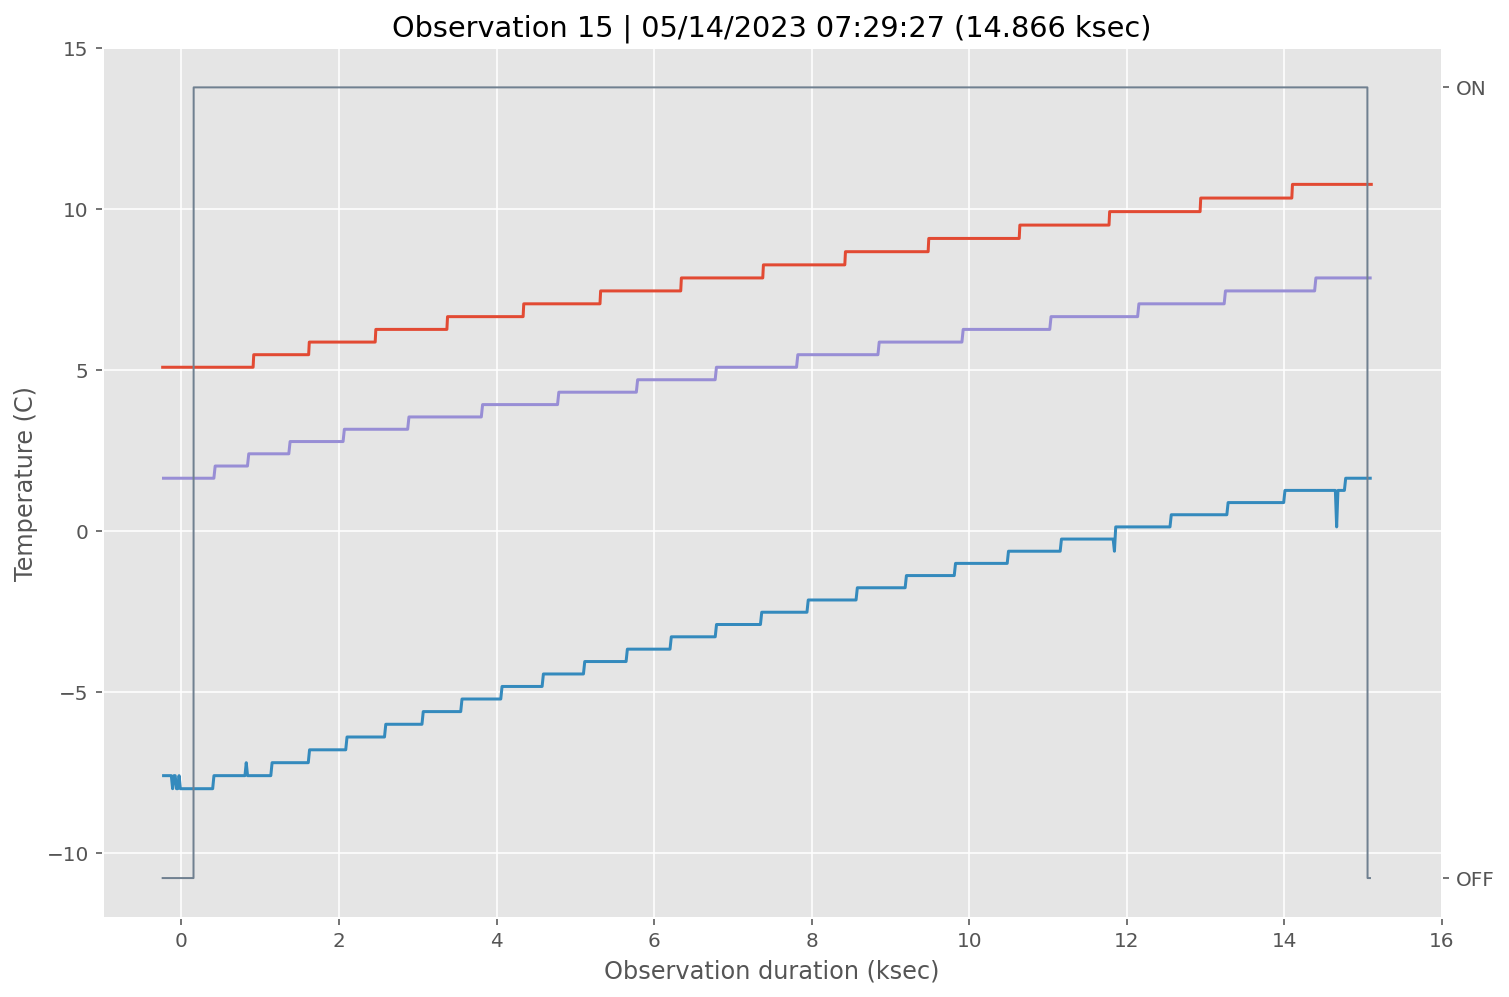

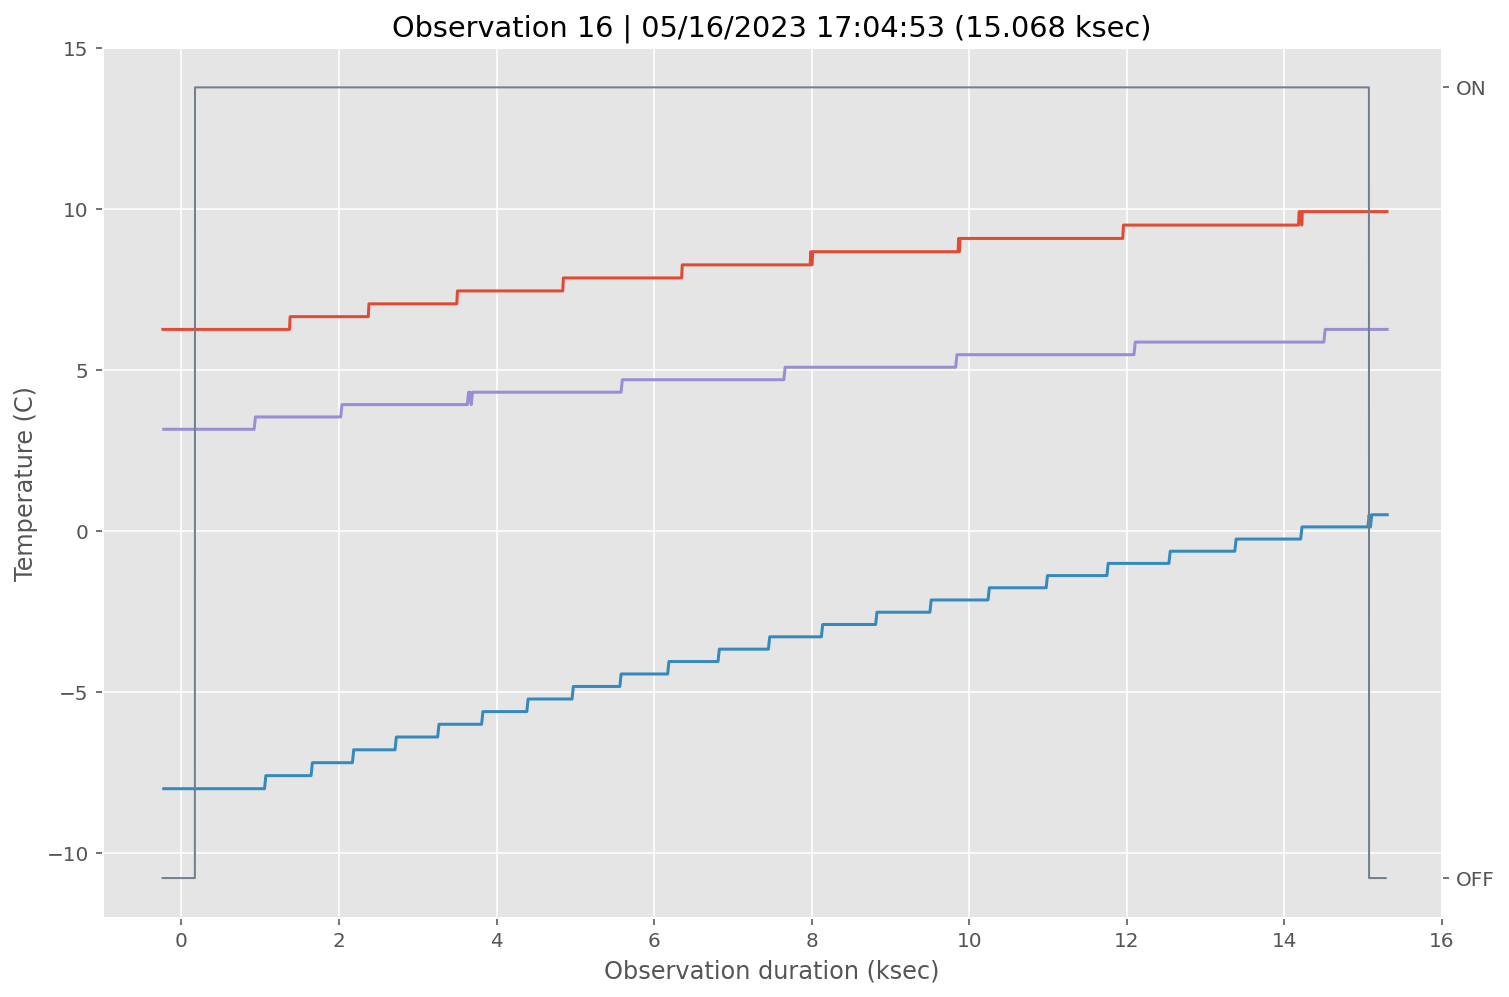

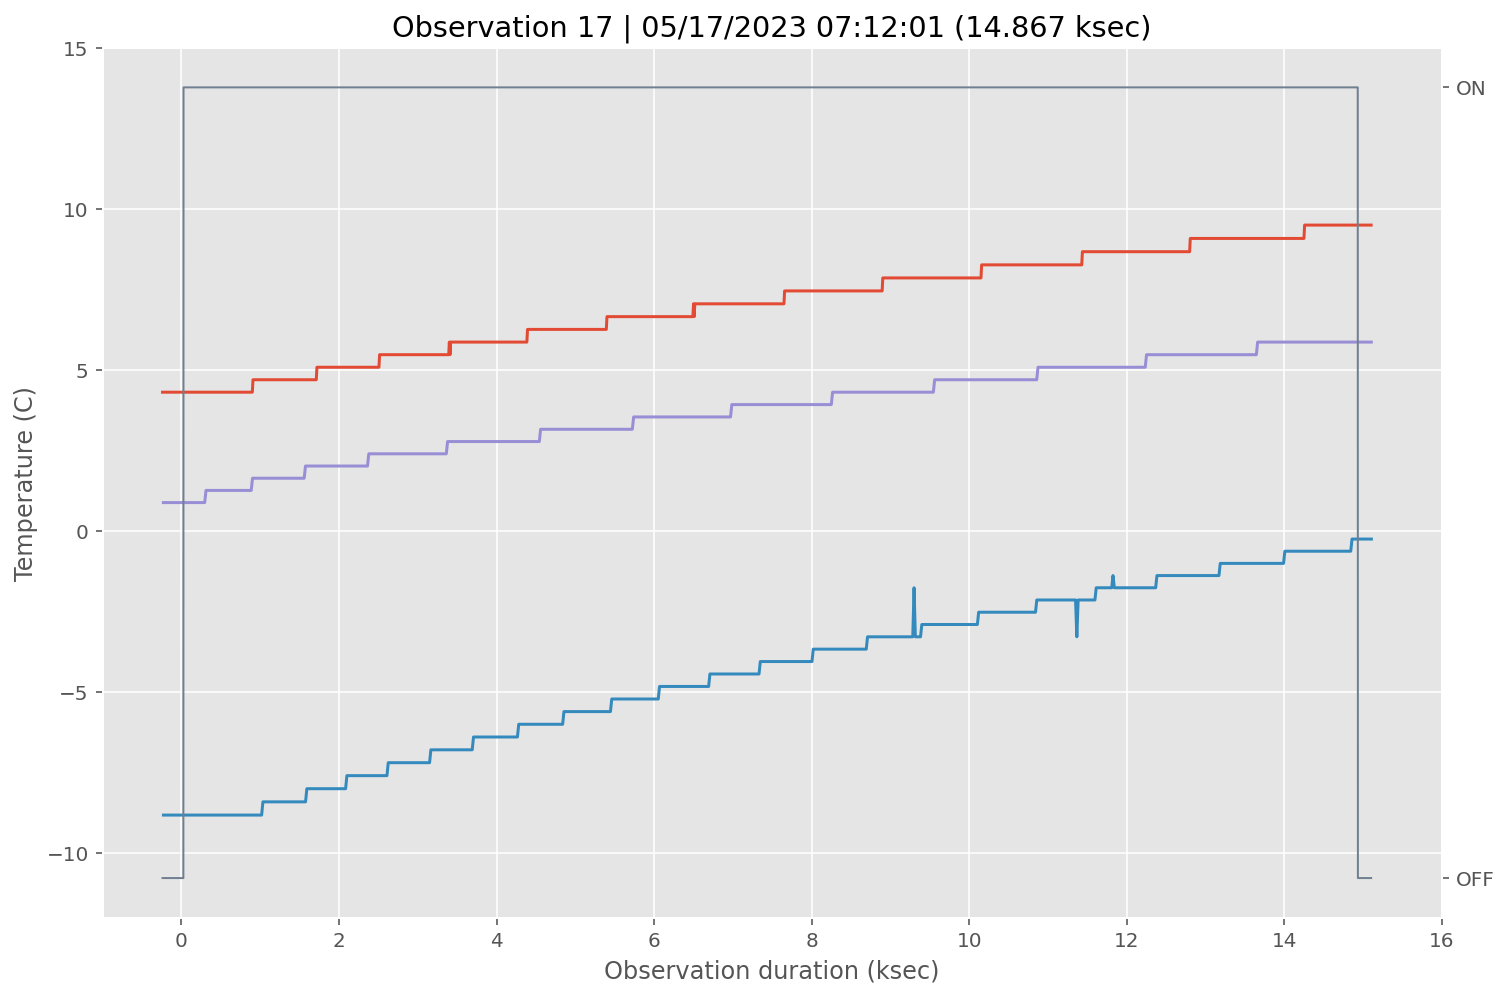

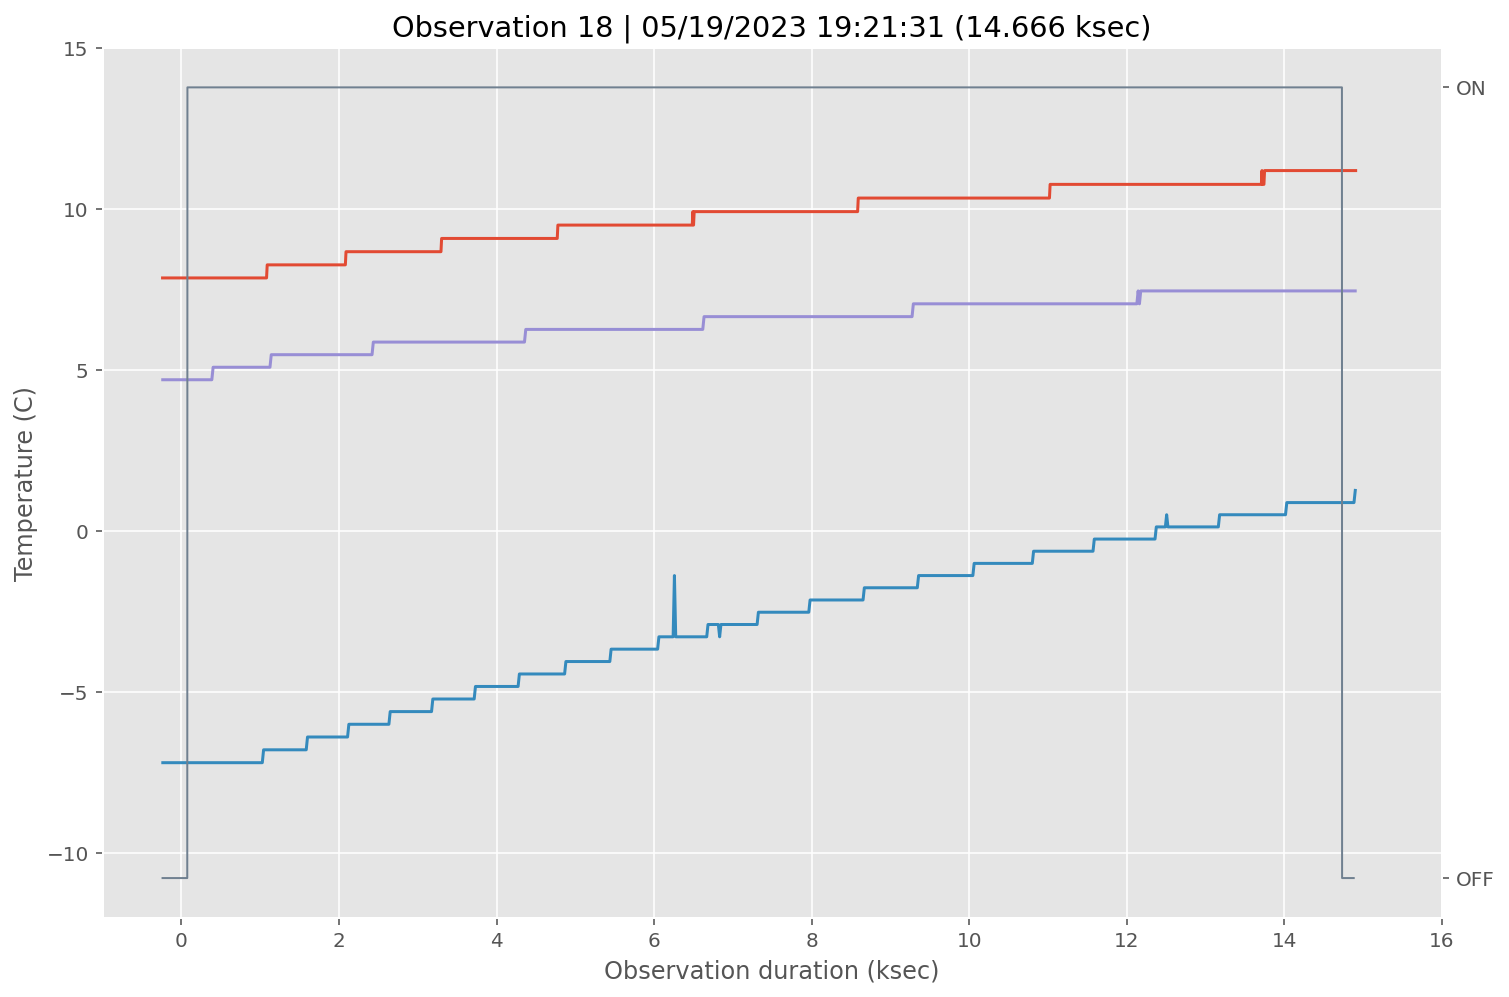

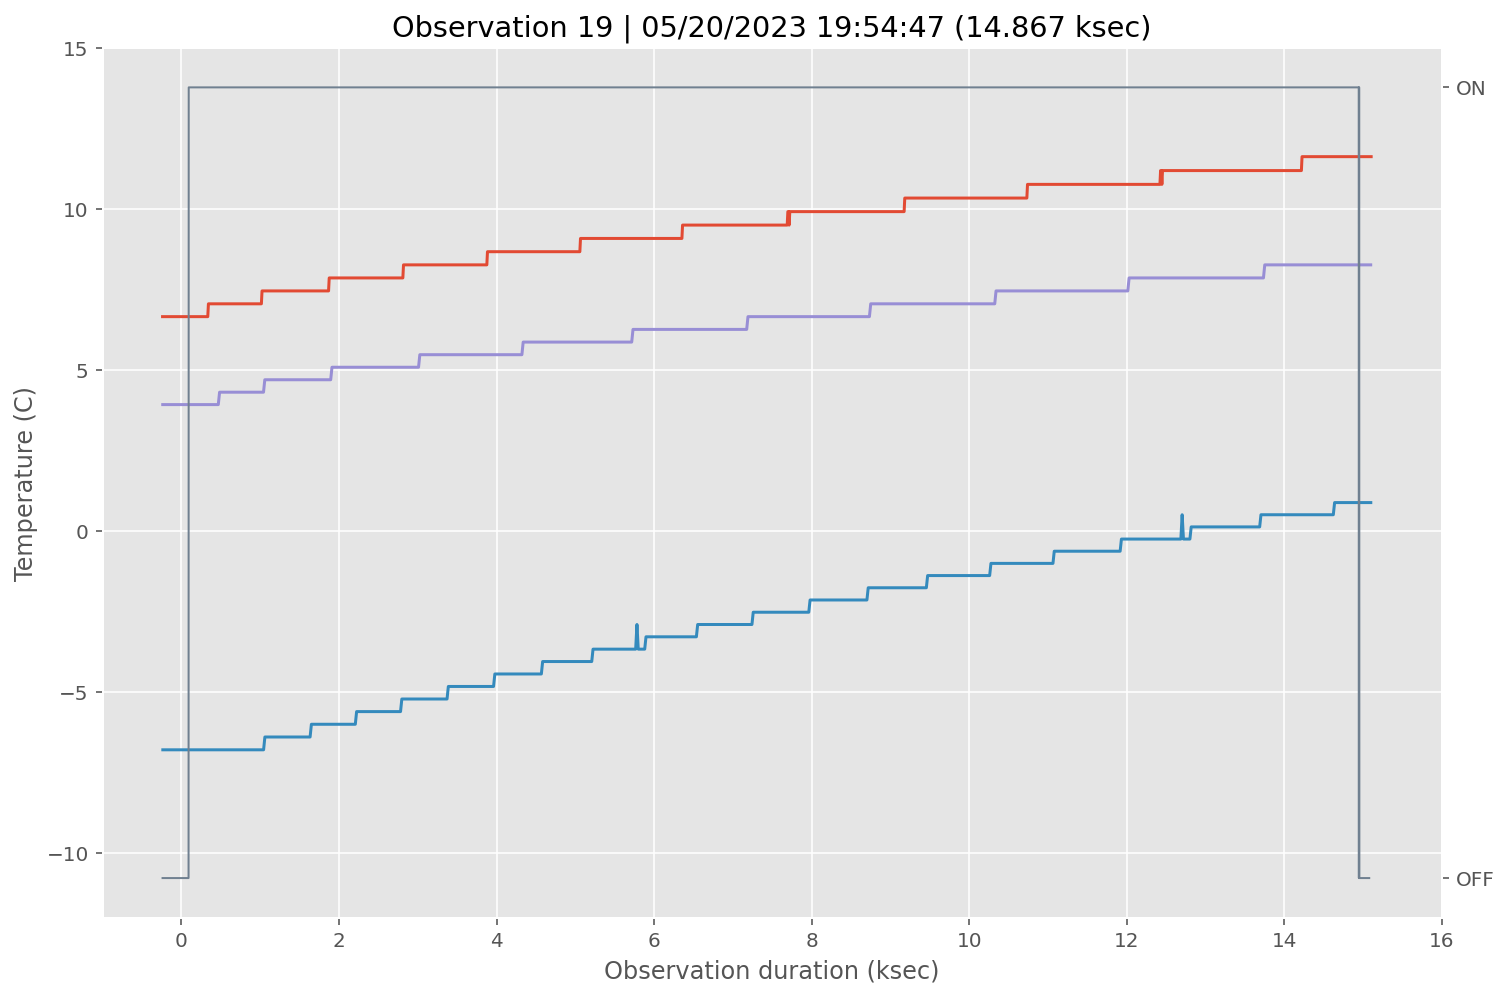

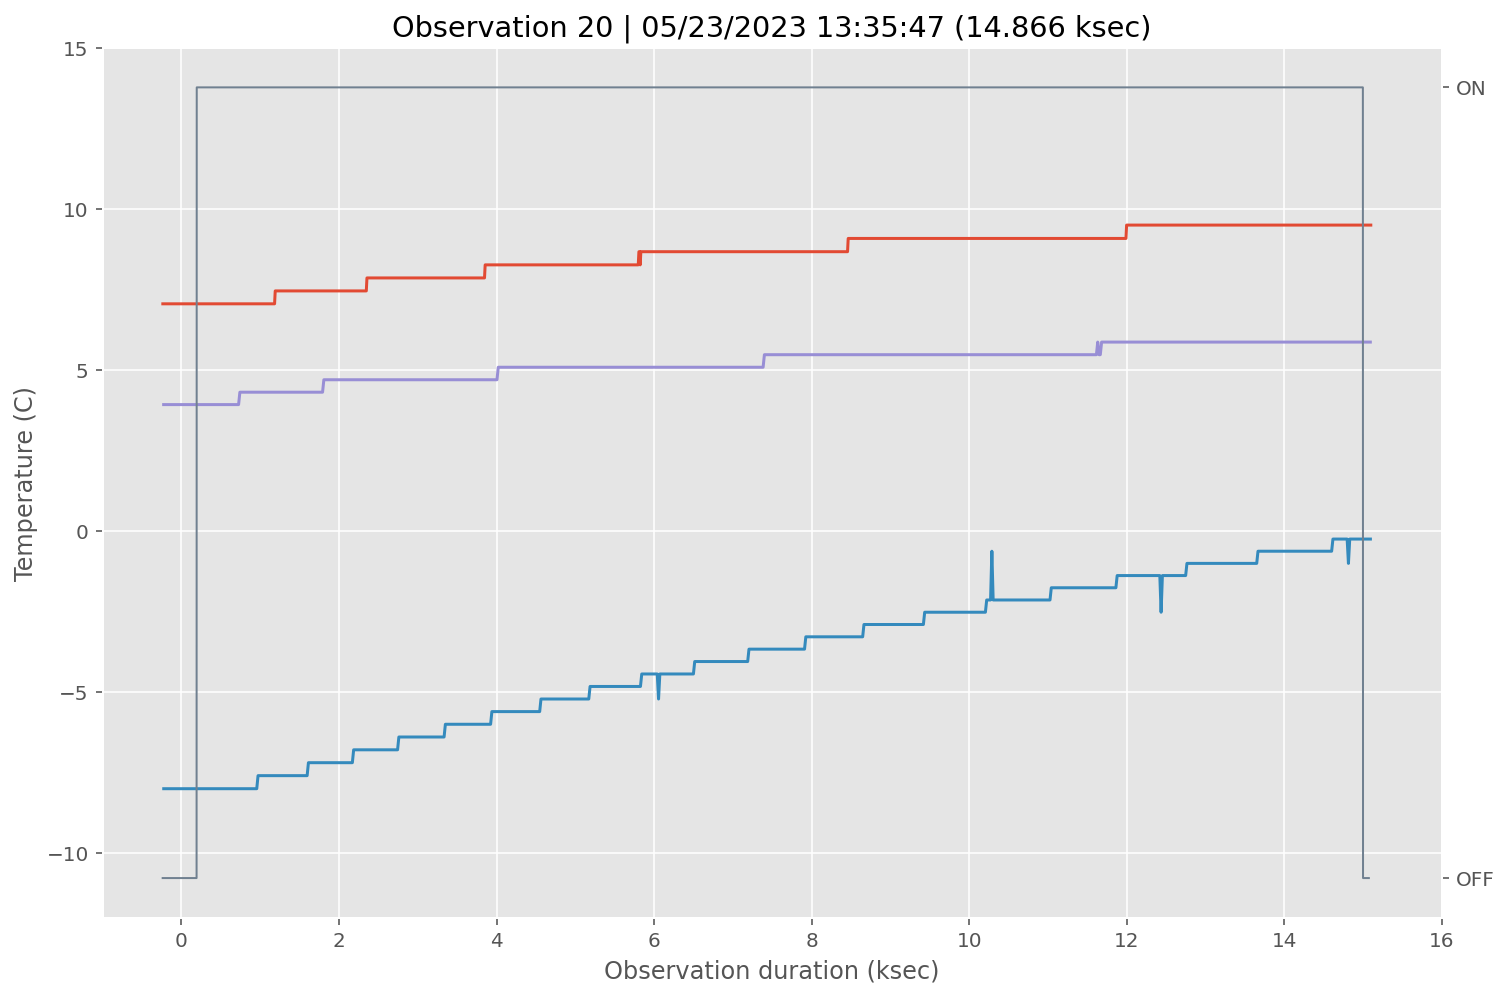

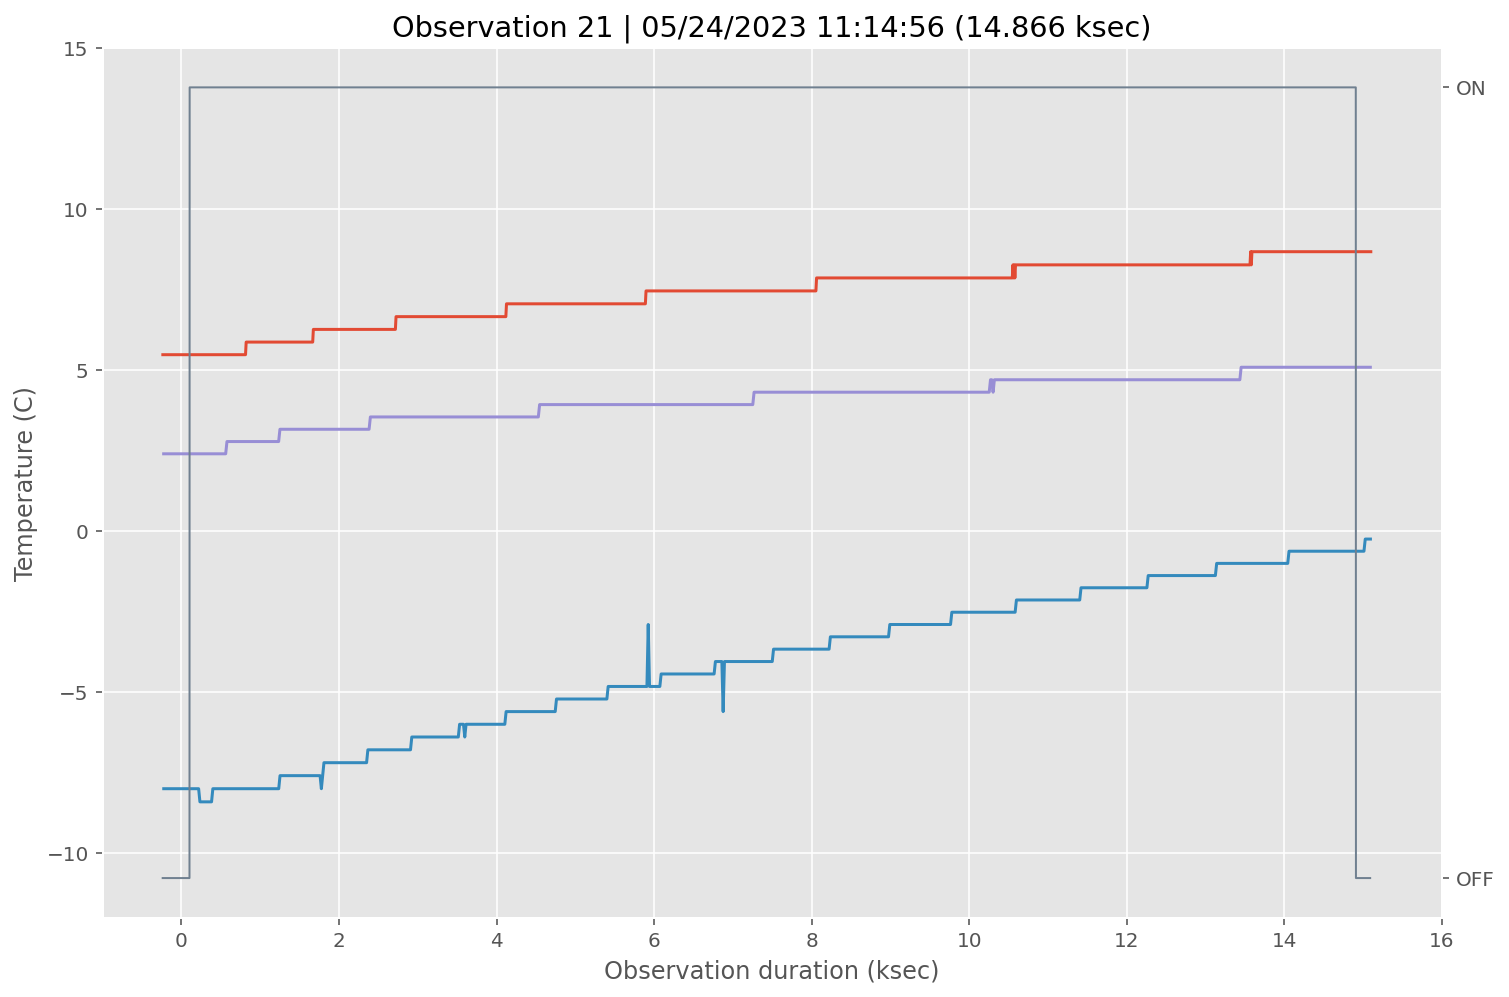

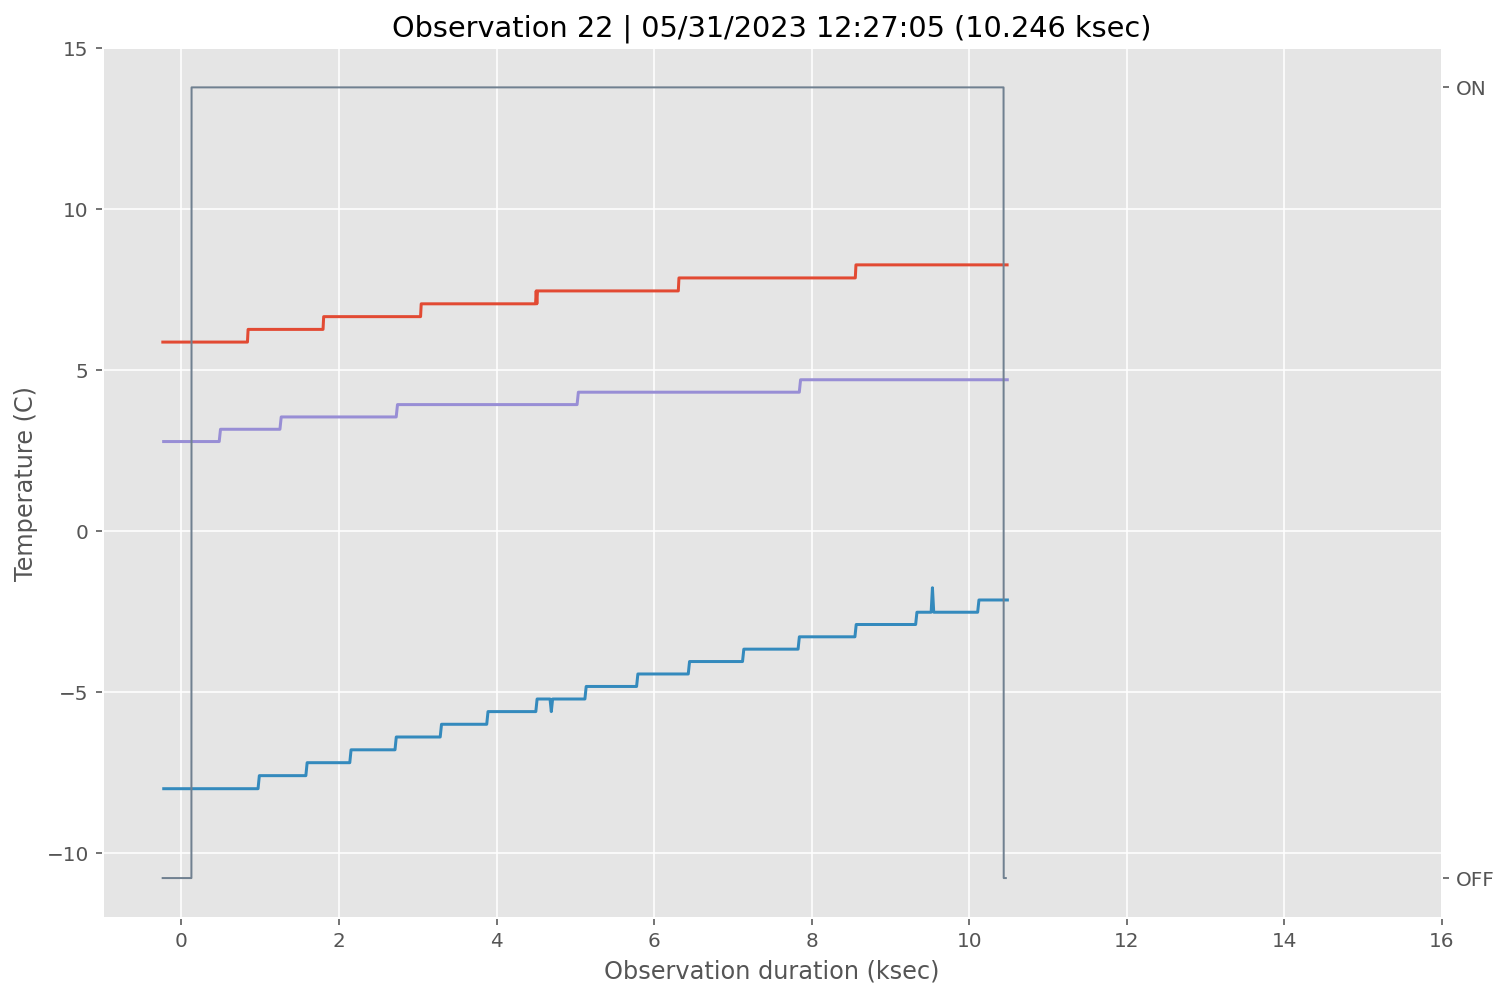

In [23]:
msidlist = ['2CEAHVPT', '2FHTRMZT', '2CHTRPZT']

# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

number_of_observations = len(start_stop_times)
cols = 2

# Compute Rows required

rows = number_of_observations // cols 

#     If one additional row is necessary -> add one:

if number_of_observations % cols != 0:
    rows += 1

# Create a Position index

plot_position = range(1,number_of_observations + 1)


# fig = plt.figure(1)

# for i in range(number_of_observations):
#     ax = fig.add_subplot(rows,cols,plot_position[i])

#     tstart = np.round(interval[0],0) - 120
#     tstop = np.round(interval[1],0) + 120 # seconds after the power-off
    

for i, interval in enumerate(start_stop_times):
    
    tstart = np.round(interval[0],0) 
    tstop = np.round(interval[1],0) 

    telem_padding = 240 # seconds before and after the power-off

    duration_in_ksec = (tstop - tstart) / 1000

    power_states = fetch.MSIDset(state_msids, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)
    telem = fetch.MSIDset(msidlist, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)


    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot((telem['2CEAHVPT'].times - tstart) / 1000, telem['2CEAHVPT'].vals, label='2CEAHVPT')
    ax.plot((telem['2FHTRMZT'].times - tstart) / 1000, telem['2FHTRMZT'].vals, label='2FHTRMZT')
    ax.plot((telem['2CHTRPZT'].times - tstart) / 1000, telem['2CHTRPZT'].vals, label='2CHTRPZT')

    # ax.axhline(10)
    # ax.axhline(12)

    ax2 = ax.twinx()
    ax2.plot((power_states['215PCAST'].times - tstart) / 1000, power_states['215PCAST'].vals, label='215PCAST', color='slategray', linestyle='-', linewidth=1, alpha=1)
    ax2.grid(False)

    # ax.legend()

    ax.set_ylim(-12, 15)
    ax.set_xlim(-1, 16)

    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('Observation duration (ksec)')
    ax.set_title(f'Observation {i+1} | {cxc2dt(tstart).strftime("%m/%d/%Y %H:%M:%S")} ({duration_in_ksec} ksec)')




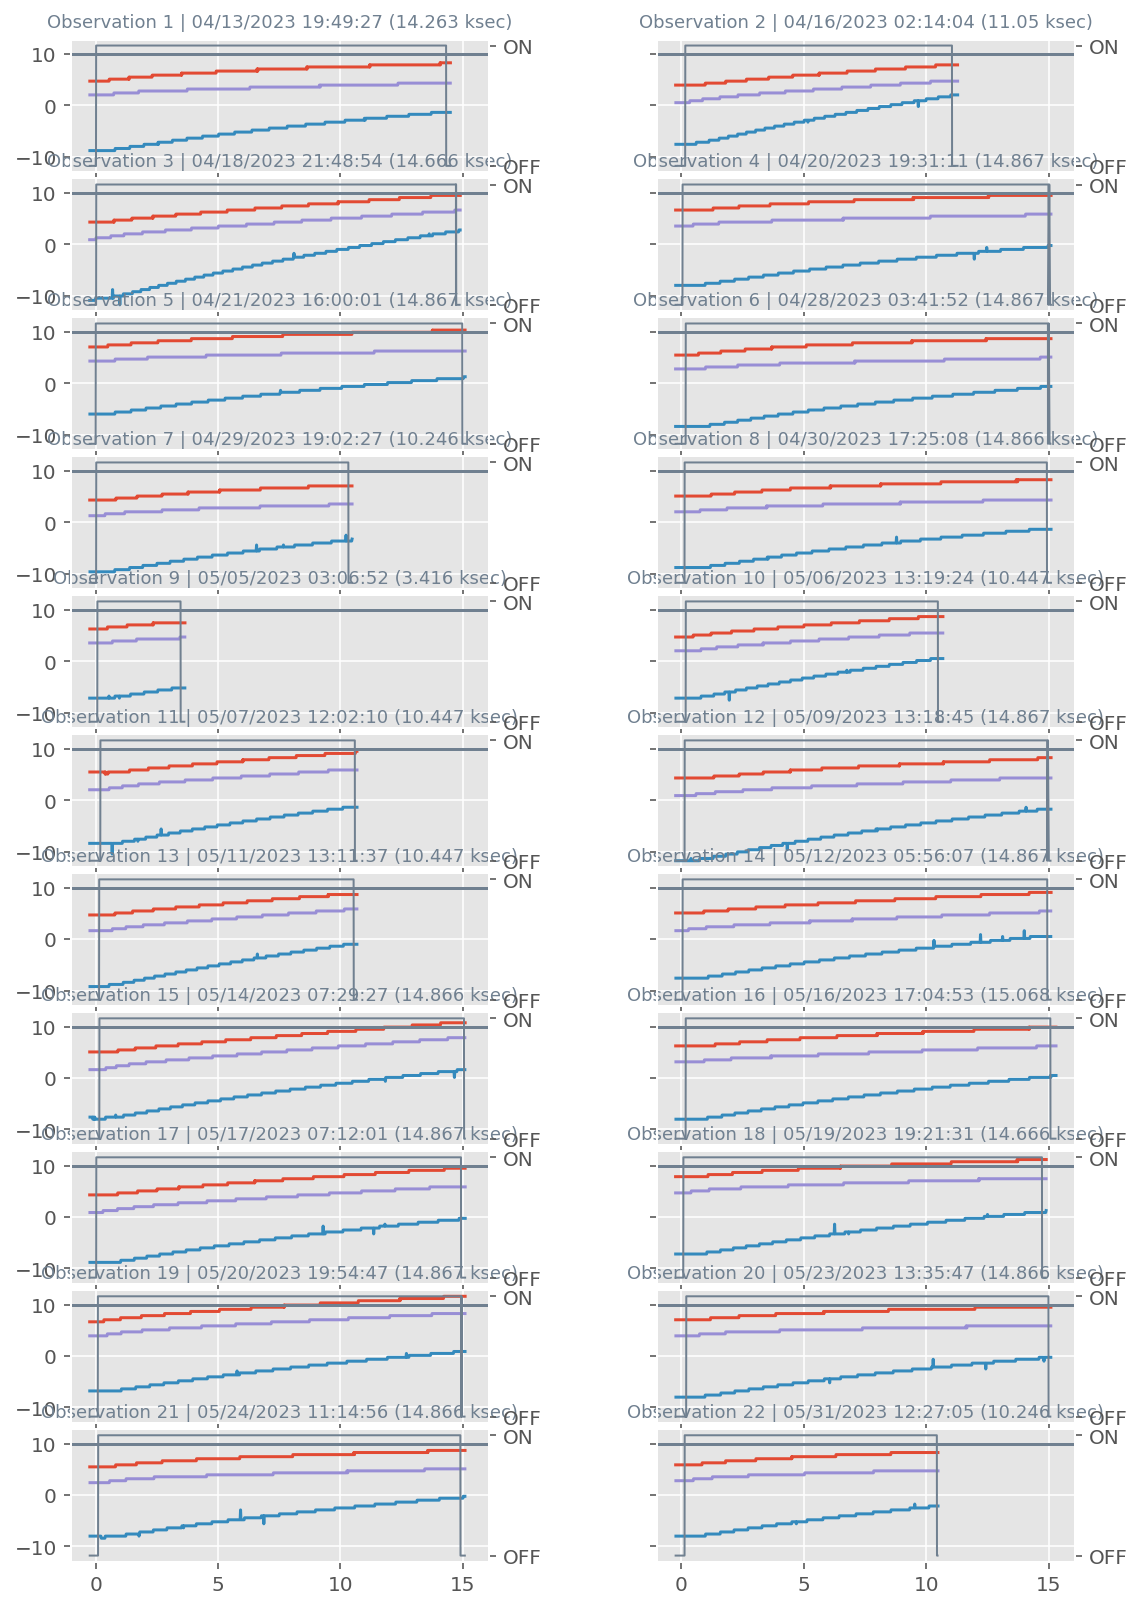

In [25]:

msidlist = ['2CEAHVPT', '2FHTRMZT', '2CHTRPZT']

fig, axs = plt.subplots(nrows=11, ncols=2, sharex=True, sharey=True, figsize=(9, 14))
plt.subplots_adjust(wspace=0.4, hspace=0.05)

for i, ax in enumerate(axs.flat):

    interval = start_stop_times[i]
    
    tstart = np.round(interval[0],0) 
    tstop = np.round(interval[1],0) 

    telem_padding = 240 # seconds before and after the power-off

    duration_in_ksec = (tstop - tstart) / 1000

    power_states = fetch.MSIDset(state_msids, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)
    telem = fetch.MSIDset(msidlist, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)

    for msid in msidlist:
        ax.plot((telem[msid].times - tstart) / 1000, telem[msid].vals, label=msid)
    # ax.plot((telem['2CEAHVPT'].times - tstart) / 1000, telem['2CEAHVPT'].vals, label='2CEAHVPT')
    # ax.plot((telem['2FHTRMZT'].times - tstart) / 1000, telem['2FHTRMZT'].vals, label='2FHTRMZT')
    # ax.plot((telem['2CHTRPZT'].times - tstart) / 1000, telem['2CHTRPZT'].vals, label='2CHTRPZT')

    ax.axhline(10, color='slategray')
    # ax.axhline(12)

    ax2 = ax.twinx()
    ax2.plot((power_states['215PCAST'].times - tstart) / 1000, power_states['215PCAST'].vals, label='215PCAST', color='slategray', linestyle='-', linewidth=1, alpha=1)
    ax2.grid(False)

    # ax.legend()

    # ax.set_ylim(-12, 16)
    # ax.set_xlim(-1, 16)

    # ax.set_ylabel('Temperature (C)')
    # ax.set_xlabel('Observation duration (ksec)')
    ax.set_title(f'Observation {i+1} | {cxc2dt(tstart).strftime("%m/%d/%Y %H:%M:%S")} ({duration_in_ksec} ksec)', fontsize=9, color= 'slategray')

plt.savefig('/Users/grant/Desktop/bigplot.pdf', dpi=300, bbox_inches='tight')


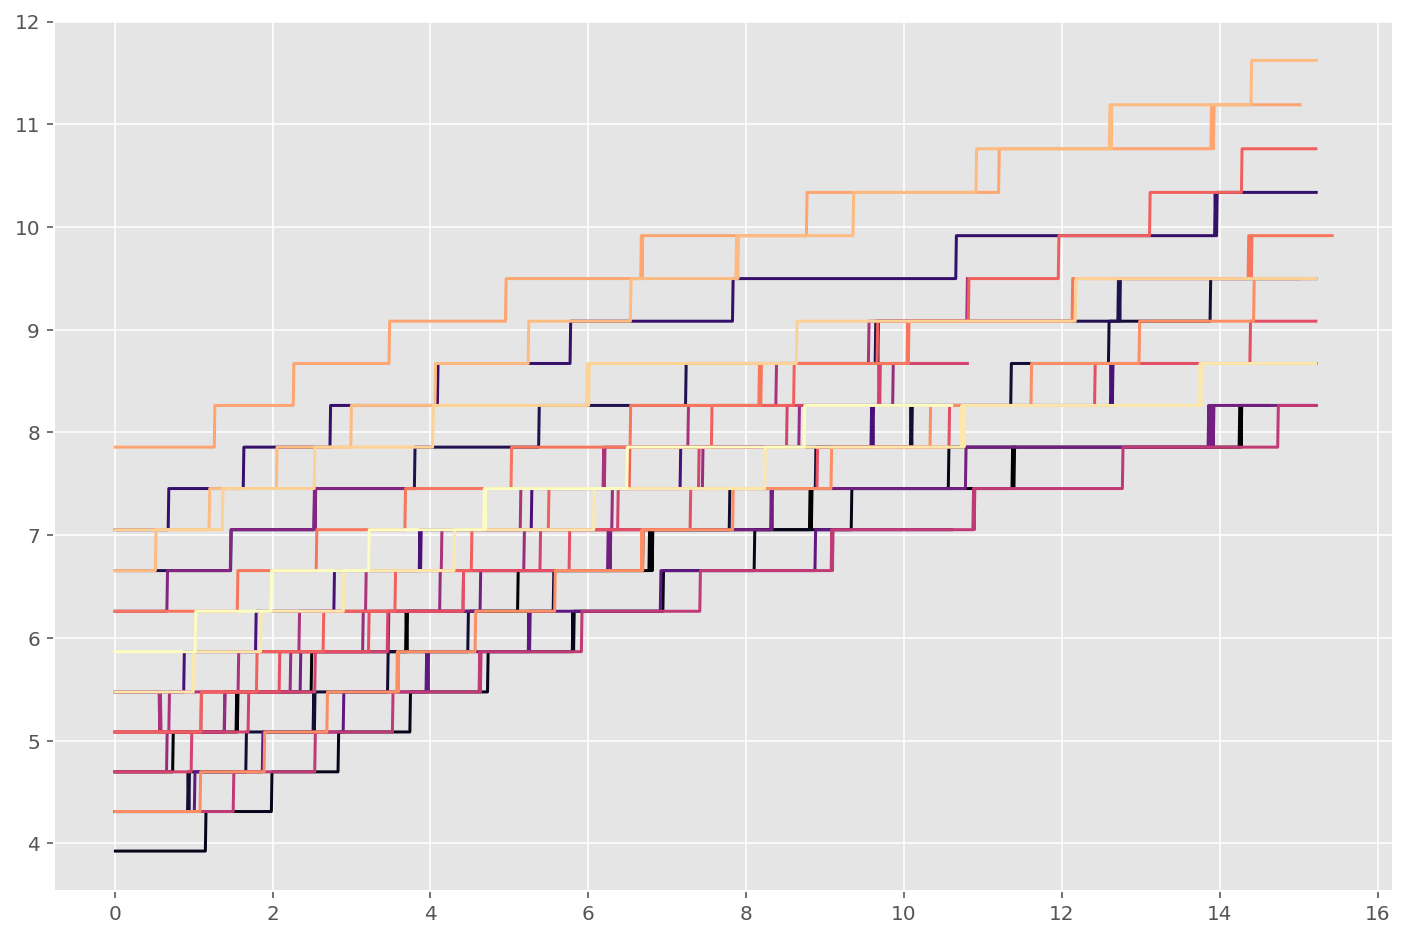

In [334]:
msidlist = ['2CEAHVPT']

telemetry_list = []
time_intervals = []
durations_in_seconds = []
start_temps = []
stop_temps = []
temperature_changes = []

for interval in start_stop_times:
    tstart = np.round(interval[0],0) - 180
    tstop = np.round(interval[1],0) + 180 # seconds after the power-off

    time_intervals.append((tstart, tstop))

    telem = fetch.MSIDset(msidlist, start=tstart, stop=tstop,  filter_bad=False)
    telemetry_list.append(telem)

    duration_in_sec = (tstop - tstart)
    durations_in_seconds.append(duration_in_sec)

    start_temps.append(telem['2CEAHVPT'].vals[0])
    stop_temps.append(telem['2CEAHVPT'].vals[-1])

    temperature_change = telem['2CEAHVPT'].vals[-1] - telem['2CEAHVPT'].vals[0]
    temperature_changes.append(temperature_change)


colors = plt.cm.magma(np.linspace(0, 1, len(start_stop_times)))

fig, ax = plt.subplots(figsize=(12,8))

for i, telem in enumerate(telemetry_list):
    time_zero = time_intervals[i][0]
    ax.plot((telem['2CEAHVPT'].times - time_zero) / 1000, telem['2CEAHVPT'].vals, label=f'{i}', color=colors[i])



durations_in_seconds = np.array(durations_in_seconds)
start_temps = np.array(start_temps)
stop_temps = np.array(stop_temps)
temperature_changes = np.array(temperature_changes)

    

/var/folders/s_/7v014tss6d18cgg702db9d5r0000gn/T/ipykernel_72082/2256327939.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc, label='Starting temperature (C)')


Text(0.5, 0, 'Observation duration (ksec)')

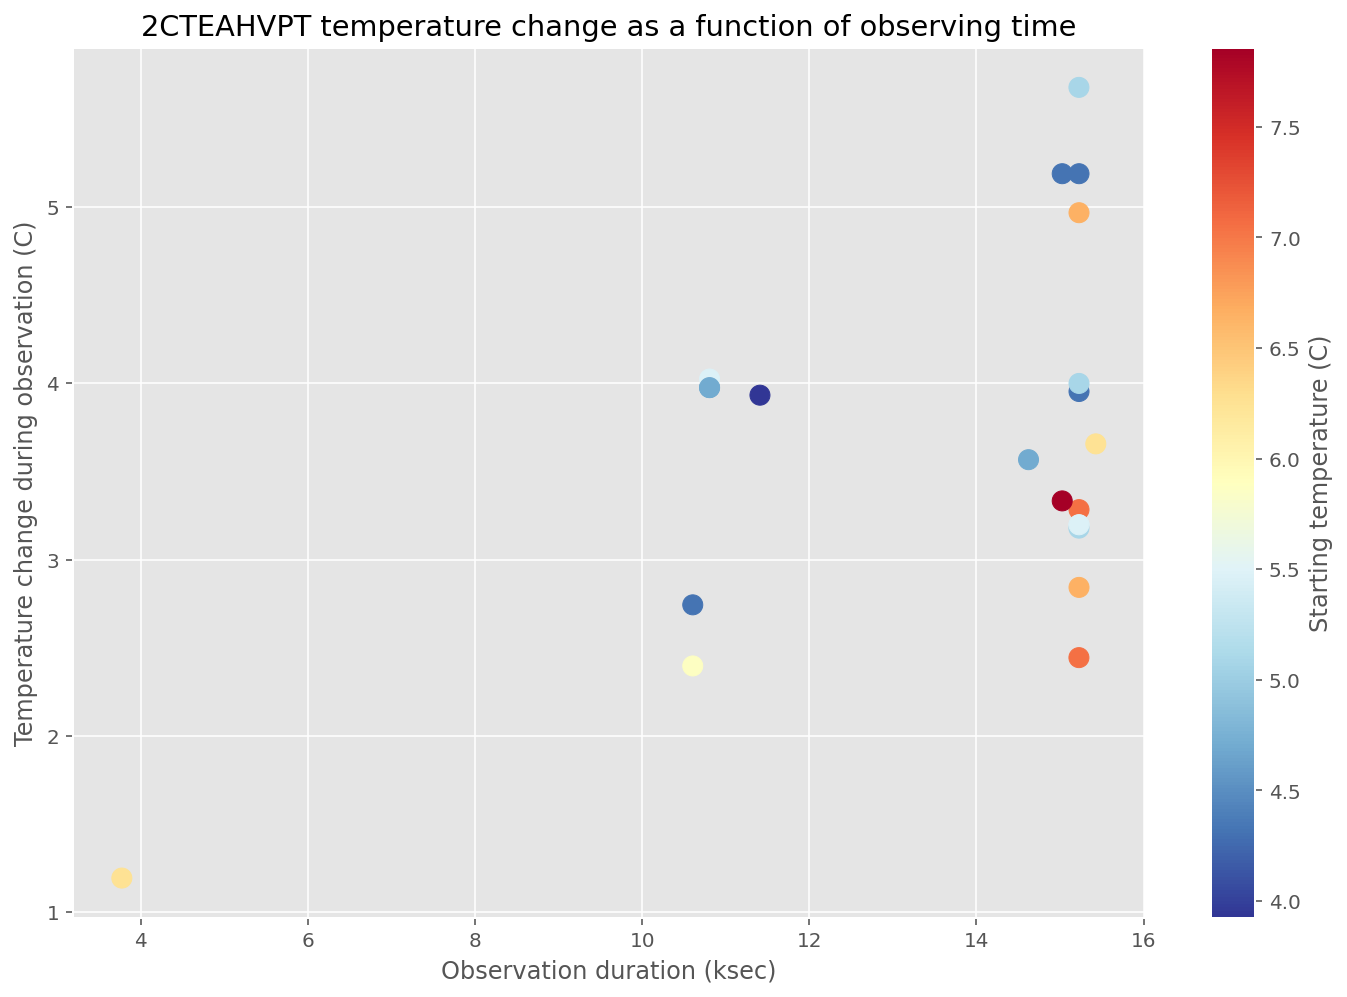

In [343]:
fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(durations_in_seconds / 1000, temperature_changes, c=start_temps, cmap='RdYlBu_r', marker='o', s=100)
plt.title('2CTEAHVPT temperature change as a function of observing time')
plt.colorbar(sc, label='Starting temperature (C)')
ax.set_ylabel('Temperature change during observation (C)')
ax.set_xlabel('Observation duration (ksec)')

Text(0.5, 0, 'Temperature change during observation (C)')

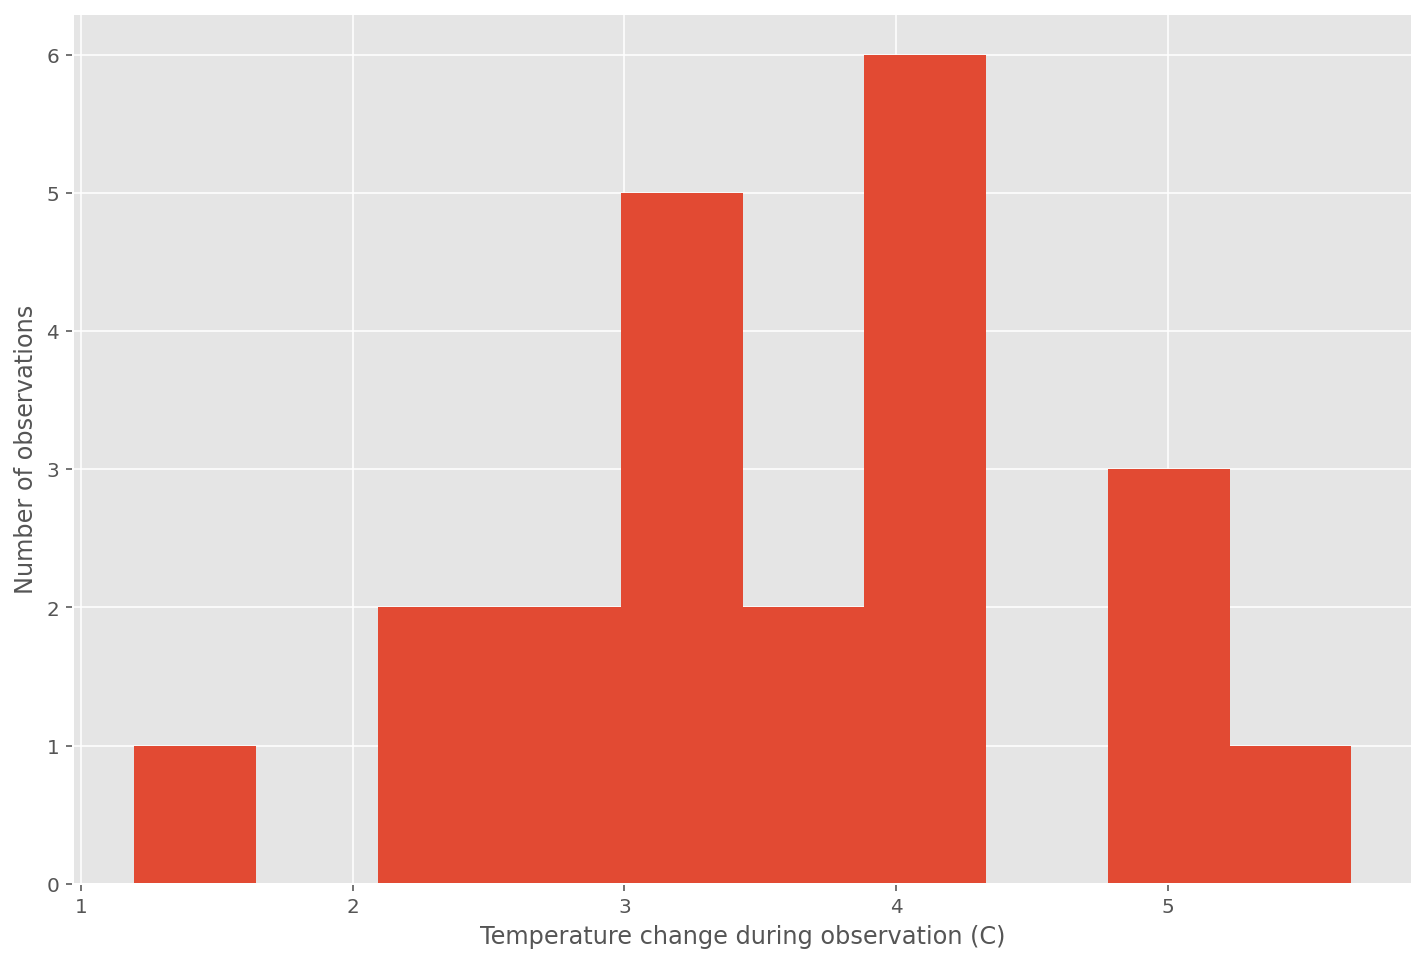

In [344]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(temperature_changes)
ax.set_ylabel('Number of observations')
ax.set_xlabel('Temperature change during observation (C)')
# ax.scatter(durations_in_seconds, temperature_changes, c=start_temps, cmap='magma')


Text(0.5, 0, 'Temperature change per kilosecond of observation (C/ksec)')

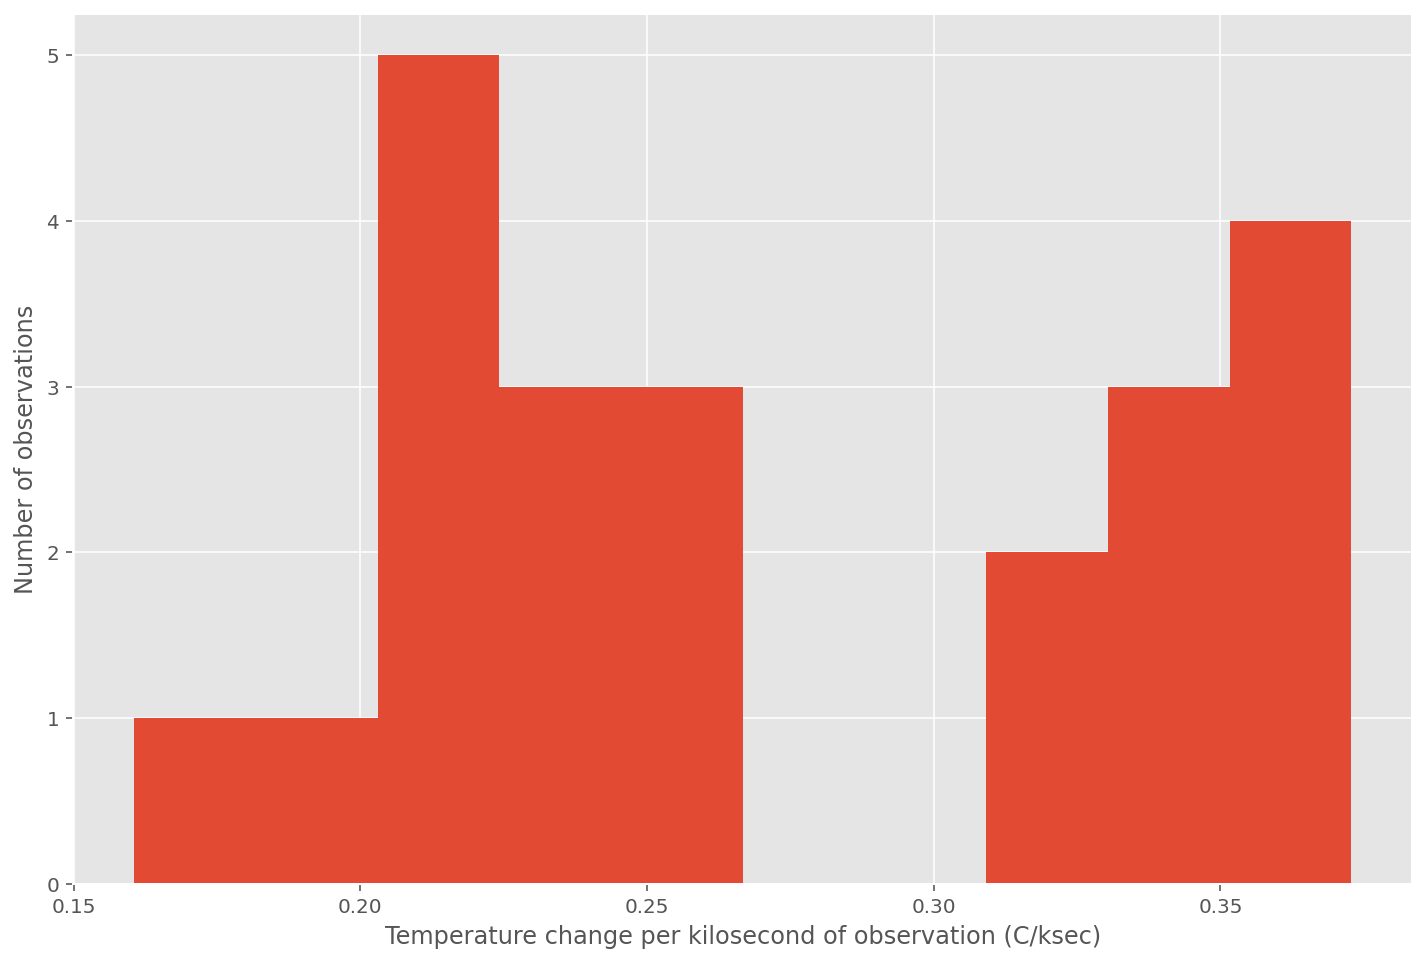

In [350]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(temperature_changes / (durations_in_seconds / 1000))
ax.set_ylabel('Number of observations')
ax.set_xlabel('Temperature change per kilosecond of observation (C/ksec)')
# ax.scatter(durations_in_seconds, temperature

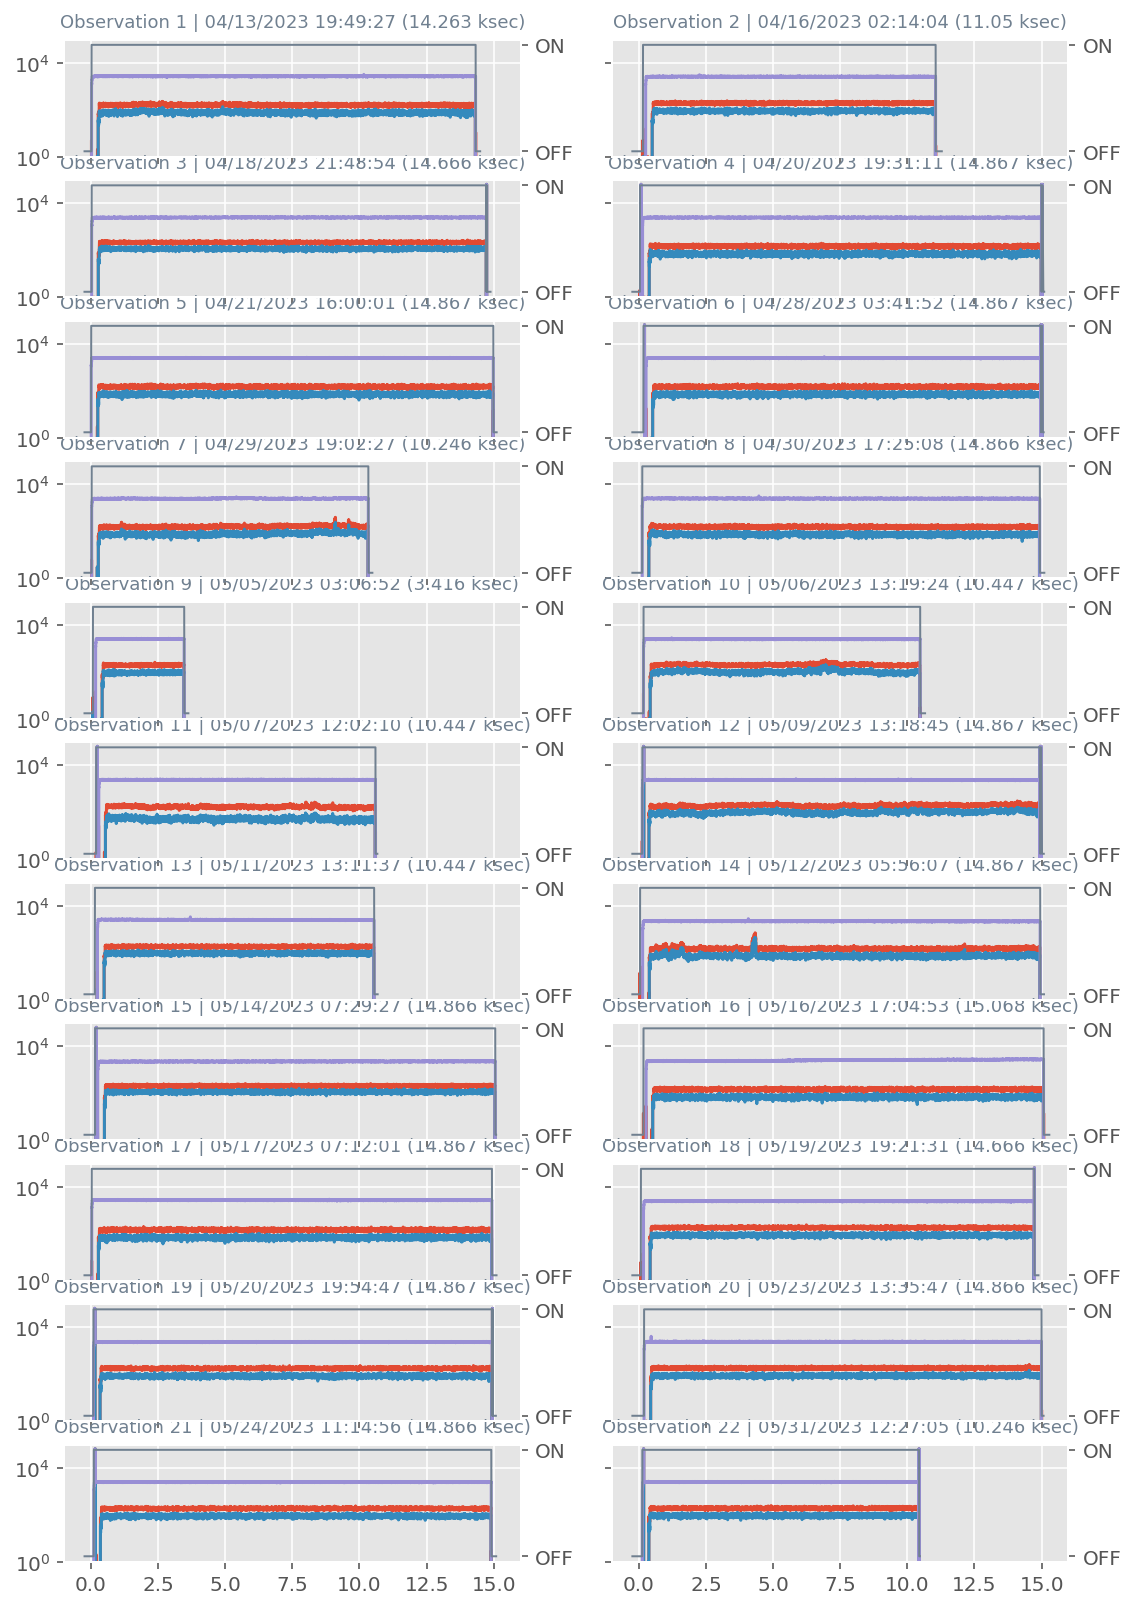

In [33]:
# msidlist = ['2CEAHVPT', '2FHTRMZT', '2CHTRPZT']
msidlist = ['2TLEV1RT', '2VLEV1RT', '2SHEV1RT']
fig, axs = plt.subplots(nrows=11, ncols=2, sharex=True, sharey=True, figsize=(9, 14))
# plt.subplots_adjust(wspace=1.2, hspace=1.2)

for i, ax in enumerate(axs.flat):

    interval = start_stop_times[i]
    
    tstart = np.round(interval[0],0) 
    tstop = np.round(interval[1],0) 

    telem_padding = 240 # seconds before and after the power-off

    duration_in_ksec = (tstop - tstart) / 1000

    power_states = fetch.MSIDset(state_msids, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)
    telem = fetch.MSIDset(msidlist, start=tstart - telem_padding, stop=tstop + telem_padding,  filter_bad=False)

    for msid in msidlist:
        ax.plot((telem[msid].times - tstart) / 1000, telem[msid].vals, label=msid)
    # ax.plot((telem['2CEAHVPT'].times - tstart) / 1000, telem['2CEAHVPT'].vals, label='2CEAHVPT')
    # ax.plot((telem['2FHTRMZT'].times - tstart) / 1000, telem['2FHTRMZT'].vals, label='2FHTRMZT')
    # ax.plot((telem['2CHTRPZT'].times - tstart) / 1000, telem['2CHTRPZT'].vals, label='2CHTRPZT')

    # ax.axhline(10, color='slategray')
    # ax.axhline(12)

    ax2 = ax.twinx()
    ax2.plot((power_states['215PCAST'].times - tstart) / 1000, power_states['215PCAST'].vals, label='215PCAST', color='slategray', linestyle='-', linewidth=1, alpha=1)
    ax2.grid(False)

    ax.set_yscale('log')

    # ax.legend()

    ax.set_ylim(1, 100000)
    ax.set_xlim(-1, 16)

    # ax.set_ylabel('Temperature (C)')
    # ax.set_xlabel('Observation duration (ksec)')
    ax.set_title(f'Observation {i+1} | {cxc2dt(tstart).strftime("%m/%d/%Y %H:%M:%S")} ({duration_in_ksec} ksec)', fontsize=9, color= 'slategray')

plt.savefig('/Users/grant/Desktop/bigplot.pdf', dpi=300, bbox_inches='tight')